# Git Clone GPSat
this is need if running in colab

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# TODO: allow for mounting of gdrive
# TODO: allow for checking out a branch
# TODO: plot hyper parameters

if IN_COLAB:
    
    import os
    import re

    # change to working directory
    work_dir = "/content"
    
    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)
    
    # clone repository
    !git clone https://github.com/CPOMUCL/GPSat.git

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)


## install the requirements

In [2]:
if IN_COLAB:
    !pip install -r requirements.txt

## install the GPSat pacakge in editable mode

In [3]:
if IN_COLAB:
    !pip install -e .


# import packages


In [4]:
# simple inline example of OI
# NOTE: there is no smoothing of hyper parameters

import os
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.postprocessing import smooth_hyperparameters
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data, plot_hyper_parameters


2024-02-06 19:58:41.059371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 19:58:41.059396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 19:58:41.060329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 19:58:41.065906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 19:58:41.745013: W tensorflow/compiler/tf2

# read in raw data


In [5]:

# read in all the *_RAW.csv files in data/example
# - get files to read
raw_files = [get_data_path("example", i)
             for i in os.listdir(get_data_path("example")) if re.search("_RAW\.csv$", i)]

# read in, add source col
tmp = []
for rw in raw_files:
    source = re.sub("_RAW\.csv$", "", os.path.basename(rw))
    _ = pd.read_csv(rw)
    _['source'] = source
    tmp.append(_)
df = pd.concat(tmp)


# convert lon, lat, datetime to x, y, t - to be used as the coordinate space
# - x,y are in meters, t in days
df['x'], df['y'] = WGS84toEASE2_New(lon=df['lon'], lat=df['lat'], lat_0=90, lon_0=0)
df['t'] = df['datetime'].values.astype("datetime64[D]").astype(float)



# Pre-process (bin) raw data


In [6]:
# bin by date, source to a 50x50km grid
# - returns a DataSet
bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t', 'source'],
                              val_col='z',
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500000.0, 4500000.0],
                              y_range=[-4500000.0, 4500000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()


'bin_data_by': 1.716 seconds



# plot binned data

'plot_pcolormesh': 0.043 seconds


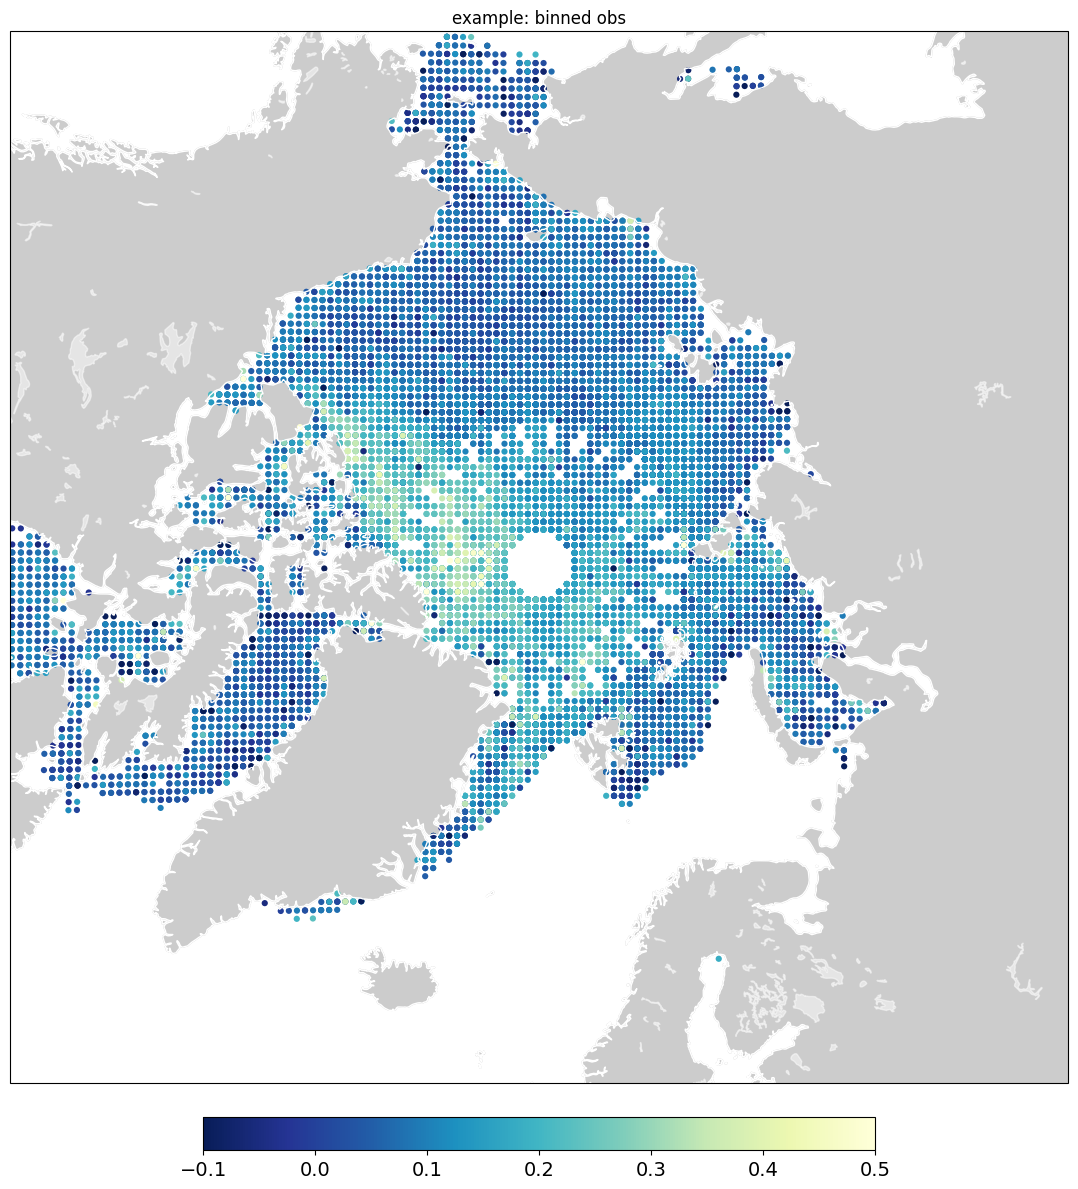

In [7]:
# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84_New(bin_df['x'], bin_df['y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
# plot value range
vmin, vmax = -0.1, 0.5

plot_pcolormesh(ax=ax,
                lon=bin_df['lon'],
                lat=bin_df['lat'],
                plot_data=bin_df['z'],
                title="example: binned obs",
                scatter=True,
                vmin=vmin, 
                vmax=vmax,
                s=20,
                fig=fig,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()

# expert locations - on evenly spaced grid


In [8]:
# - spaced every 200km for some x,y range
expert_x_range = [-750000.0, 1000000.0]
expert_y_range = [-500000.0, 1250000.0]
xy_grid = grid_2d_flatten(x_range=expert_x_range,
                          y_range=expert_y_range,
                          step_size=200_000)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())


# plot expert locations


'plot_pcolormesh': 0.009 seconds


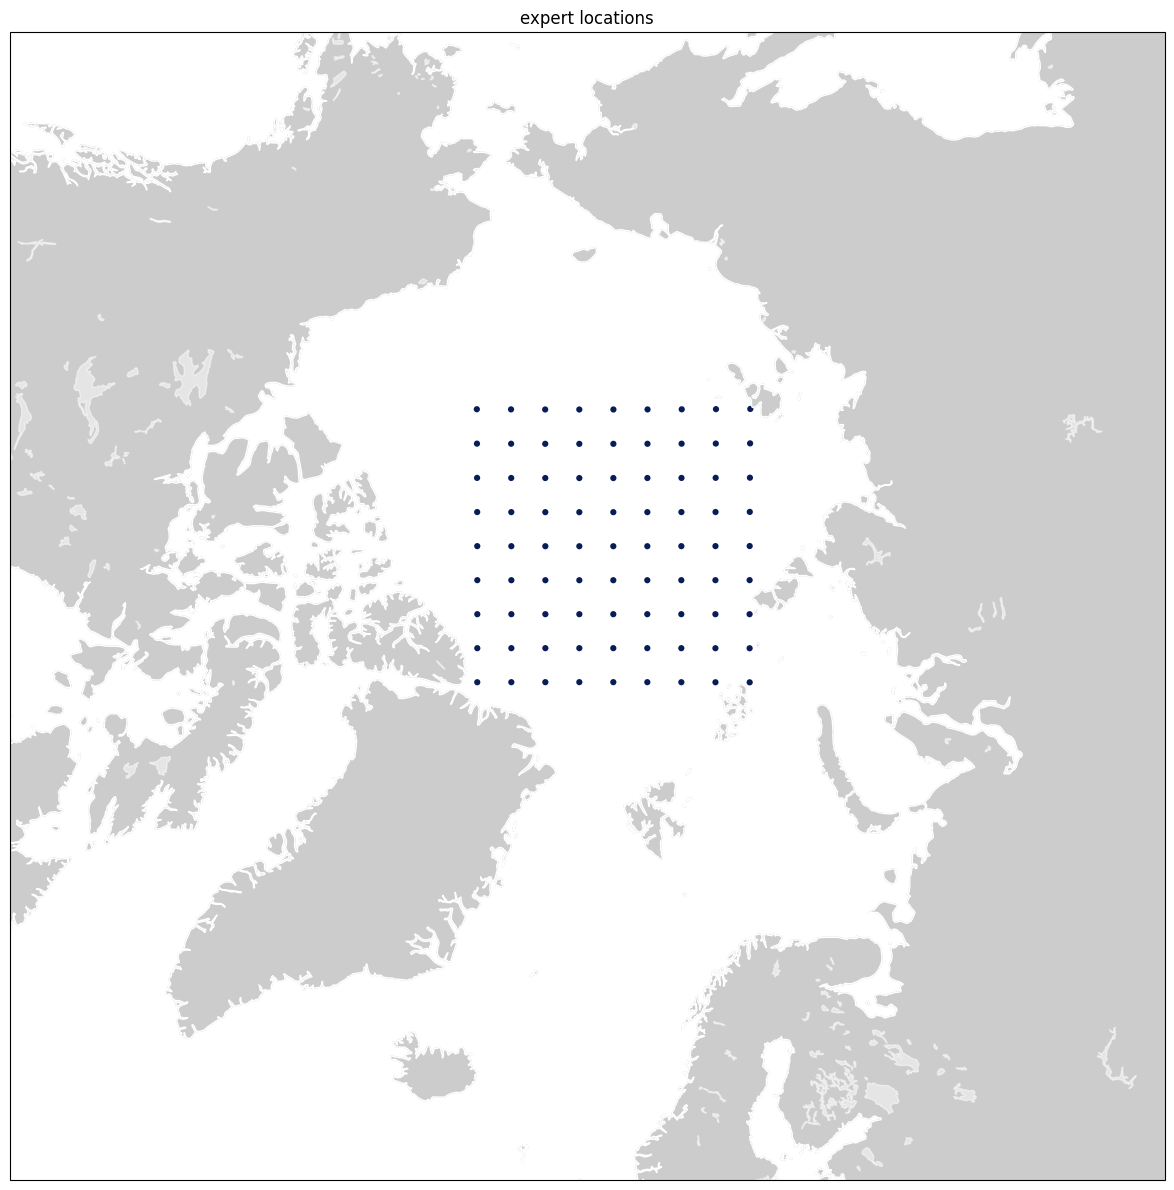

In [9]:

eloc['lon'], eloc['lat'] = EASE2toWGS84_New(eloc['x'], eloc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()


# prediction locations


In [10]:

# - spaced every 5km
pred_xy_grid = grid_2d_flatten(x_range=expert_x_range,
                               y_range=expert_y_range,
                               step_size=5_000)

# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(pred_xy_grid, columns=['x', 'y'])



# plot prediction locations


'plot_pcolormesh': 0.028 seconds


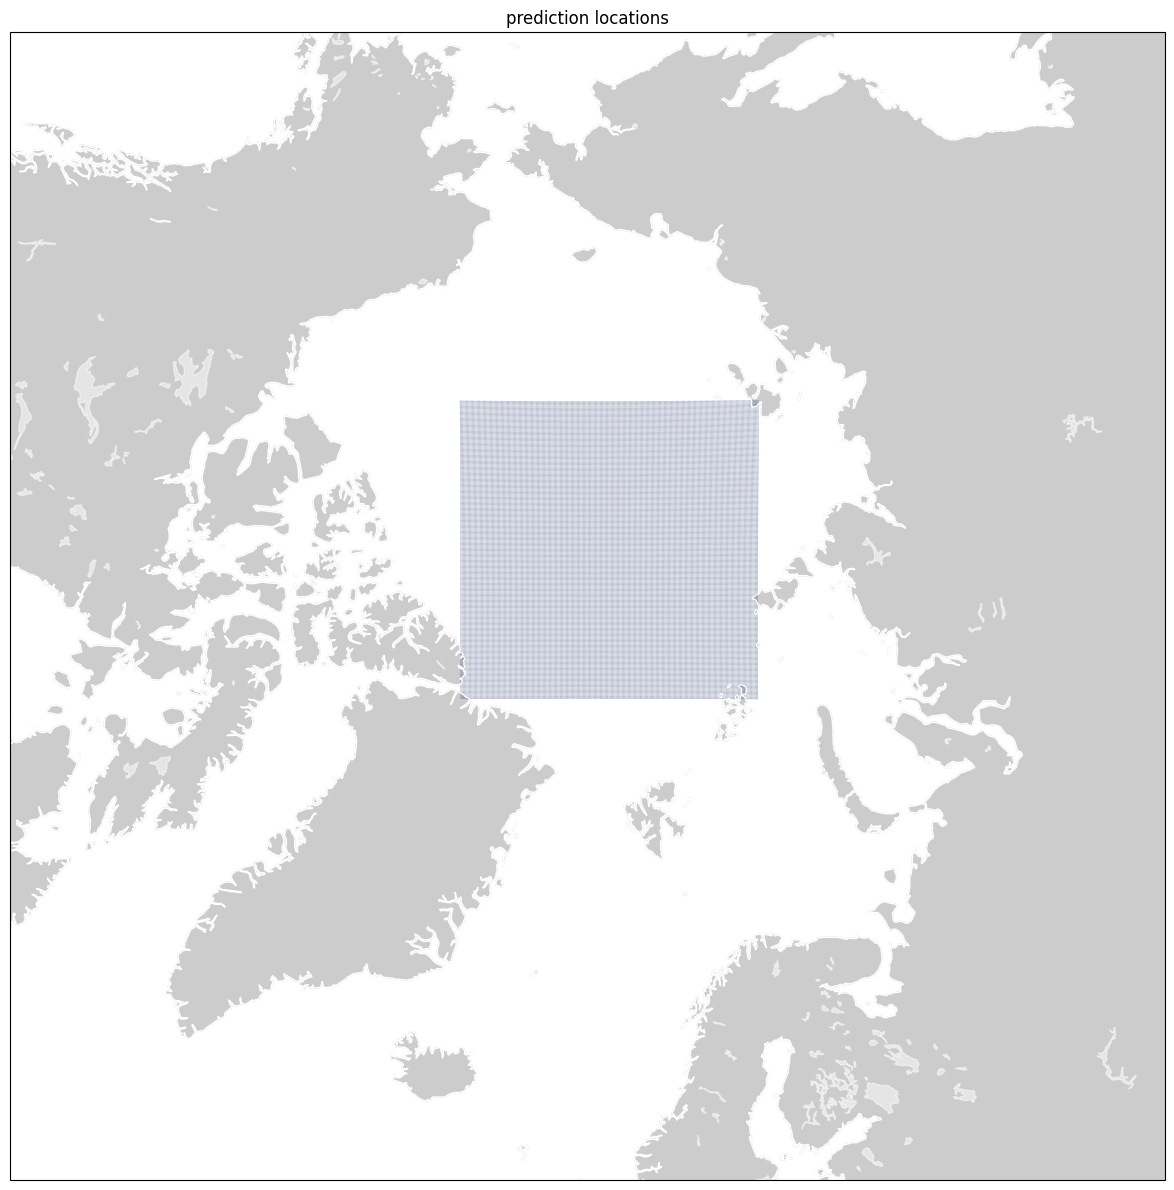

In [11]:
ploc['lon'], ploc['lat'] = EASE2toWGS84_New(ploc['x'], ploc['y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0), #np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                extent=[-180, 180, 60, 90])

plt.tight_layout()
plt.show()



# configurations for Local Expert OI


In [12]:


# observation data
data = {
    "data_source": bin_df,
    "obs_col": "z",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": "t",
            "comp": "<=",
            "val": 4
        },
        {
            "col": "t",
            "comp": ">=",
            "val": -4
        },
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<",
            "val": 300_000
        }
    ]
}

# local expert locations
local_expert = {
    "source": eloc
}

# model
model = {
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [50000, 50000, 1]
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [600000, 600000, 9]
        }
    }
}

# prediction locations
# -
pred_loc = {
    "method": "from_dataframe",
    "df": ploc,
    "max_dist": 200_000
}


# Local Expert OI

NOTE: in Colab if this falls over due to Tensorflow error try: Runtime -> 'Restart session and run all'


In [13]:
locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)



'data_select': 0.001 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 122500 >  100
storing as str


# run optimal interpolation

In [14]:
# path to store results
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True)

removing: /home/buddy/workspace/pyOI/PyOptimalInterpolation/results/inline_example.h5
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

--------------------------------------------------
1 / 81
current local expert:
          x         y        t        lon       lat
0 -650000.0 -400000.0  18326.0 -58.392498  83.16251
'data_select': 0.001 seconds
'load': 0.001 seconds
'local_data_select': 0.006 seconds
number obs: 185
found GPU
setting lengthscales to: [1. 1. 1.]


2024-02-06 19:58:55.997188: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:58:56.032414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:58:56.032597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'__init__': 1.490 seconds
'get_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:58:59.040825: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-06 19:58:59.040856: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:110] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-02-06 19:58:59.041484: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-06 19:58:59.041532: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-02-06 19:58:59.103725: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-06 19:58:59.103758: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:110] Couldn't get ptxas version : FAIL

**********
optimization failed!
'optimise_parameters': 2.942 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.505014  , 11.99994671,  1.76969386]) 
kernel_variance: 0.03619428867670382
likelihood_variance: 0.0034123112200423835
'predict': 0.071 seconds
total run time : 4.74 seconds
--------------------------------------------------
2 / 81
current local expert:
          x         y        t        lon        lat
1 -450000.0 -400000.0  18326.0 -48.366461  84.607409
'local_data_select': 0.006 seconds
number obs: 372
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:00.733179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:00.733536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:00.733718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.589 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([5.15076616, 2.89242905, 8.99999884]) 
kernel_variance: 0.02145153568328419
likelihood_variance: 0.0033281389266486476
'predict': 0.088 seconds
total run time : 0.92 seconds
--------------------------------------------------
3 / 81
current local expert:
          x         y        t        lon        lat
2 -250000.0 -400000.0  18326.0 -32.005383  85.775828
'local_data_select': 0.006 seconds
number obs: 522
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.012 seconds


2024-02-06 19:59:01.655583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:01.655820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:01.655959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.985 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([3.80898952, 2.11934605, 8.99999403]) 
kernel_variance: 0.013721280139908868
likelihood_variance: 0.0021208672977122344
'predict': 0.102 seconds
total run time : 1.35 seconds
--------------------------------------------------
4 / 81
current local expert:
         x         y        t       lon        lat
3 -50000.0 -400000.0  18326.0 -7.125016  86.390271
'local_data_select': 0.006 seconds
number obs: 524
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:03.006063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:03.006331: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:03.006497: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.856 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([4.13236455, 7.13418982, 8.99999693]) 
kernel_variance: 0.008659555052542194
likelihood_variance: 0.0017819874985017029
'predict': 0.100 seconds
total run time : 1.21 seconds
--------------------------------------------------
5 / 81
current local expert:
          x         y        t        lon        lat
4  150000.0 -400000.0  18326.0  20.556045  86.174494
'local_data_select': 0.006 seconds
number obs: 521
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:04.214348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:04.214648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:04.214797: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.893 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.82086256, 6.50986233, 8.9999138 ]) 
kernel_variance: 0.015750753216626563
likelihood_variance: 0.001656276487074589
'predict': 0.102 seconds
total run time : 1.24 seconds
--------------------------------------------------
6 / 81
current local expert:
          x         y        t        lon        lat
5  350000.0 -400000.0  18326.0  41.185925  85.239918
'local_data_select': 0.006 seconds
number obs: 452
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:05.456544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:05.456879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:05.457079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.697 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([7.52863141, 4.64432449, 8.99816113]) 
kernel_variance: 0.012332374642534876
likelihood_variance: 0.0016064269032242133
'predict': 0.094 seconds
total run time : 1.04 seconds
--------------------------------------------------
7 / 81
current local expert:
          x         y        t        lon        lat
6  550000.0 -400000.0  18326.0  53.972627  83.908178
'local_data_select': 0.006 seconds
number obs: 388
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:06.500482: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:06.500718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:06.500858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.632 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99997451,  5.84557475,  8.99995939]) 
kernel_variance: 0.013672943451053021
likelihood_variance: 0.0017779150883479673
'predict': 0.079 seconds
total run time : 0.96 seconds
--------------------------------------------------
8 / 81
current local expert:
          x         y        t        lon        lat
7  750000.0 -400000.0  18326.0  61.927513  82.383864
'local_data_select': 0.006 seconds
number obs: 578
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:07.460831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:07.461114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:07.461255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.039 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.23302158, 6.05453636, 8.99999774]) 
kernel_variance: 0.005305420221331343
likelihood_variance: 0.0031445474244621717
'predict': 0.107 seconds
total run time : 1.39 seconds
--------------------------------------------------
9 / 81
current local expert:
          x         y        t        lon        lat
8  950000.0 -400000.0  18326.0  67.166346  80.760613
'local_data_select': 0.006 seconds
number obs: 781
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:08.852807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:08.853122: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:08.853260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.709 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([4.03840706, 3.16135093, 8.99999781]) 
kernel_variance: 0.003377438278123986
likelihood_variance: 0.002853091502297337
'predict': 0.113 seconds
total run time : 2.08 seconds
--------------------------------------------------
10 / 81
current local expert:
          x         y        t        lon        lat
9 -650000.0 -200000.0  18326.0 -72.897271  83.908178
'local_data_select': 0.006 seconds
number obs: 319
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'set_lengthscales_constraints': 0.011 seconds


2024-02-06 19:59:10.936951: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:10.937217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:10.937368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 0.632 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.54299909, 7.66517786, 3.06270696]) 
kernel_variance: 0.03504260885853151
likelihood_variance: 0.0032057298354966277
'predict': 0.073 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 1.11 seconds
--------------------------------------------------
11 / 81
current local expert:
           x         y        t        lon        lat
10 -450000.0 -200000.0  18326.0 -66.037511  85.589966
'local_data_select': 0.006 seconds
number obs: 532
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:12.051632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:12.051861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:12.051997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 1.382 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 7.31640003, 10.33445303,  2.28706107]) 
kernel_variance: 0.02597760005718268
likelihood_variance: 0.0026816258872181383
'predict': 0.110 seconds
total run time : 1.75 seconds
--------------------------------------------------
12 / 81
current local expert:
           x         y        t        lon        lat
11 -250000.0 -200000.0  18326.0 -51.340192  87.133307
'local_data_select': 0.006 seconds
number obs: 558
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'set_lengthscales_constraints': 0.009 seconds


2024-02-06 19:59:13.801966: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:13.802180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:13.802316: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.123 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([5.99285044, 9.6462249 , 8.99999404]) 
kernel_variance: 0.02273719660793839
likelihood_variance: 0.0022095119870949712
'predict': 0.126 seconds
total run time : 1.56 seconds
--------------------------------------------------
13 / 81
current local expert:
          x         y        t        lon        lat
12 -50000.0 -200000.0  18326.0 -14.036243  88.154198
'local_data_select': 0.006 seconds
number obs: 508
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:15.360495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:15.360761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:15.360913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.768 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([5.06319868, 4.56724228, 8.99998779]) 
kernel_variance: 0.010393604158189358
likelihood_variance: 0.0015243138612848761
'predict': 0.103 seconds
total run time : 1.12 seconds
--------------------------------------------------
14 / 81
current local expert:
           x         y        t        lon        lat
13  150000.0 -200000.0  18326.0  36.869898  87.761588
'local_data_select': 0.006 seconds
number obs: 517
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:16.482990: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:16.483278: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:16.483437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.942 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([7.49905437, 5.31669163, 8.99999623]) 
kernel_variance: 0.014864325955183812
likelihood_variance: 0.0014122221432150907
'predict': 0.107 seconds
total run time : 1.30 seconds
--------------------------------------------------
15 / 81
current local expert:
           x         y        t        lon        lat
14  350000.0 -200000.0  18326.0  60.255119  86.390271
'local_data_select': 0.006 seconds
number obs: 566
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:17.788354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:17.788622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:17.788763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.788 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.23366592, 4.73858556, 7.87252404]) 
kernel_variance: 0.012247729040991657
likelihood_variance: 0.0016189703296423316
'predict': 0.115 seconds
total run time : 1.20 seconds
--------------------------------------------------
16 / 81
current local expert:
           x         y        t        lon        lat
15  550000.0 -200000.0  18326.0  70.016893  84.758396
'local_data_select': 0.006 seconds
number obs: 428
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:18.992630: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:18.992931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:18.993087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.729 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99999971, 10.48968786,  8.9999161 ]) 
kernel_variance: 0.008624360593065575
likelihood_variance: 0.0015314106541690386
'predict': 0.091 seconds
total run time : 1.10 seconds
--------------------------------------------------
17 / 81
current local expert:
           x         y        t        lon        lat
16  750000.0 -200000.0  18326.0  75.068583  83.045966
'local_data_select': 0.006 seconds
number obs: 577
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:20.095648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:20.095922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:20.096063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.959 seconds
'get_parameters': 0.009 seconds
parameters:
lengthscales: array([9.06088852, 7.77444177, 8.99999669]) 
kernel_variance: 0.006107414684623288
likelihood_variance: 0.0023128393544580017
'predict': 0.128 seconds
total run time : 1.35 seconds
--------------------------------------------------
18 / 81
current local expert:
           x         y        t        lon        lat
17  950000.0 -200000.0  18326.0  78.111342  81.299147
'local_data_select': 0.006 seconds
number obs: 829
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:21.446997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:21.447374: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:21.447541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.907 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([5.84796514, 6.11086057, 8.99999616]) 
kernel_variance: 0.0034816098550222454
likelihood_variance: 0.0029654040199200127
'predict': 0.129 seconds
total run time : 2.29 seconds
--------------------------------------------------
19 / 81
current local expert:
           x    y        t   lon        lat
18 -650000.0  0.0  18326.0 -90.0  84.177821
'local_data_select': 0.006 seconds
number obs: 374
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:23.736849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:23.737085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:23.737215: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 0.604 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([5.38305215, 5.35353974, 2.26091596]) 
kernel_variance: 0.03160552501896096
likelihood_variance: 0.002414549893231385
'predict': 0.076 seconds
total run time : 0.93 seconds
--------------------------------------------------
20 / 81
current local expert:
           x    y        t   lon        lat
19 -450000.0  0.0  18326.0 -90.0  85.970237
'local_data_select': 0.006 seconds
number obs: 571
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.009 seconds


2024-02-06 19:59:24.670191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:24.670426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:24.670567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 1.656 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 7.17913195, 11.99997826,  4.4716062 ]) 
kernel_variance: 0.022260295301597392
likelihood_variance: 0.0026654859251272886
'predict': 0.115 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 2.21 seconds
--------------------------------------------------
21 / 81
current local expert:
           x    y        t   lon        lat
20 -250000.0  0.0  18326.0 -90.0  87.761588
'local_data_select': 0.006 seconds
number obs: 541
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds


2024-02-06 19:59:26.876762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:26.876969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:26.877100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'set_lengthscales_constraints': 0.008 seconds
**********
optimization failed!
'optimise_parameters': 1.836 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.98631262, 11.99994416,  4.35851598]) 
kernel_variance: 0.021607876563815142
likelihood_variance: 0.001995826983297092
'predict': 0.113 seconds
total run time : 2.20 seconds
--------------------------------------------------
22 / 81
current local expert:
          x    y        t   lon        lat
21 -50000.0  0.0  18326.0 -90.0  89.552347
'local_data_select': 0.006 seconds
number obs: 510
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:29.077178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:29.077436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:29.077575: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.969 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.58350766, 11.9998263 ,  8.99999588]) 
kernel_variance: 0.011682617772537018
likelihood_variance: 0.0011755914940267376
'predict': 0.101 seconds
total run time : 1.32 seconds
--------------------------------------------------
23 / 81
current local expert:
           x    y        t   lon        lat
22  150000.0  0.0  18326.0  90.0  88.657012
'local_data_select': 0.006 seconds
number obs: 491
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:30.400955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:30.401186: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:30.401342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.839 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.69863856, 5.98223285, 8.999997  ]) 
kernel_variance: 0.013582404626789548
likelihood_variance: 0.0011619243007124859
'predict': 0.102 seconds
total run time : 1.20 seconds
--------------------------------------------------
24 / 81
current local expert:
           x    y        t   lon        lat
23  350000.0  0.0  18326.0  90.0  86.866016
'local_data_select': 0.006 seconds
number obs: 556
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:31.603541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:31.603871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:31.604069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.142 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.85378679, 6.51129719, 8.99987892]) 
kernel_variance: 0.008858730455183293
likelihood_variance: 0.0013316328652059936
'predict': 0.114 seconds
total run time : 1.52 seconds
--------------------------------------------------
25 / 81
current local expert:
           x    y        t   lon        lat
24  550000.0  0.0  18326.0  90.0  85.074192
'local_data_select': 0.006 seconds
number obs: 472
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:33.122319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:33.122661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:33.122828: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 1.143 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99999999, 11.99960607,  3.09422829]) 
kernel_variance: 0.007119779876229349
likelihood_variance: 0.0012809228513039398
'predict': 0.097 seconds
total run time : 1.49 seconds
--------------------------------------------------
26 / 81
current local expert:
           x    y        t   lon        lat
25  750000.0  0.0  18326.0  90.0  83.281065
'local_data_select': 0.006 seconds
number obs: 550
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:34.615621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:34.616003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:34.616174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.925 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99997264,  4.99684723,  8.99999927]) 
kernel_variance: 0.004836251609556071
likelihood_variance: 0.002975371792189028
'predict': 0.114 seconds
total run time : 1.30 seconds
--------------------------------------------------
27 / 81
current local expert:
           x    y        t   lon        lat
26  950000.0  0.0  18326.0  90.0  81.486158
'local_data_select': 0.006 seconds
number obs: 734
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:35.913083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:35.913325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:35.913470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.560 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([2.95886364, 3.33827646, 8.99999922]) 
kernel_variance: 0.00497027336901394
likelihood_variance: 0.003158760306280575
'predict': 0.115 seconds
total run time : 1.93 seconds
--------------------------------------------------
28 / 81
current local expert:
           x         y        t         lon        lat
27 -650000.0  200000.0  18326.0 -107.102729  83.908178
'local_data_select': 0.006 seconds
number obs: 431
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.032 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:37.847675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:37.847945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:37.848078: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.612 seconds
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([ 6.23860858, 11.99999953,  8.99999841]) 
kernel_variance: 0.02255128770278524
likelihood_variance: 0.0026550159544319702
'predict': 0.099 seconds
total run time : 0.99 seconds
--------------------------------------------------
29 / 81
current local expert:
           x         y        t         lon        lat
28 -450000.0  200000.0  18326.0 -113.962489  85.589966
'local_data_select': 0.006 seconds
number obs: 536
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:38.843600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:38.843837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:38.843974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.833 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 5.96640869, 11.99998285,  3.02445624]) 
kernel_variance: 0.016654644755707056
likelihood_variance: 0.00196508775801959
'predict': 0.112 seconds
total run time : 1.20 seconds
--------------------------------------------------
30 / 81
current local expert:
           x         y        t         lon        lat
29 -250000.0  200000.0  18326.0 -128.659808  87.133307
'local_data_select': 0.006 seconds
number obs: 561
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:40.049094: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:40.049317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:40.049459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.034 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([11.94064097, 11.98149258,  3.7785237 ]) 
kernel_variance: 0.03176021977518278
likelihood_variance: 0.0017471879406946729
'predict': 0.142 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 1.73 seconds
--------------------------------------------------
31 / 81
current local expert:
          x         y        t         lon        lat
30 -50000.0  200000.0  18326.0 -165.963757  88.154198
'local_data_select': 0.006 seconds
number obs: 527
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.009 seconds


2024-02-06 19:59:41.782546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:41.782833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:41.782980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.952 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([4.73404116, 7.58165912, 8.99999848]) 
kernel_variance: 0.008249696764273019
likelihood_variance: 0.0012345861217203412
'predict': 0.115 seconds
total run time : 1.35 seconds
--------------------------------------------------
32 / 81
current local expert:
           x         y        t         lon        lat
31  150000.0  200000.0  18326.0  143.130102  87.761588
'local_data_select': 0.006 seconds
number obs: 528
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:43.138043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:43.138272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:43.138411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.827 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 7.6053823 , 11.99993479,  8.99998682]) 
kernel_variance: 0.008591418245143163
likelihood_variance: 0.0013953640797062512
'predict': 0.110 seconds
total run time : 1.22 seconds
--------------------------------------------------
33 / 81
current local expert:
           x         y        t         lon        lat
32  350000.0  200000.0  18326.0  119.744881  86.390271
'local_data_select': 0.006 seconds
number obs: 545
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:44.361937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:44.362183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:44.362324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 1.690 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99764051, 11.99976989,  8.2436321 ]) 
kernel_variance: 0.008596866592601234
likelihood_variance: 0.0015781617266915576
'predict': 0.117 seconds
total run time : 2.07 seconds
--------------------------------------------------
34 / 81
current local expert:
           x         y        t         lon        lat
33  550000.0  200000.0  18326.0  109.983107  84.758396
'local_data_select': 0.006 seconds
number obs: 429
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:46.434987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:46.435214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:46.435353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.558 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([11.96089477, 10.99150356,  2.61197422]) 
kernel_variance: 0.00612621341436975
likelihood_variance: 0.0012808073983691627
'predict': 0.093 seconds
total run time : 0.92 seconds
--------------------------------------------------
35 / 81
current local expert:
           x         y        t         lon        lat
34  750000.0  200000.0  18326.0  104.931417  83.045966
'local_data_select': 0.006 seconds
number obs: 597
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:47.358097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:47.358389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:47.358540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.992 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.30892793, 5.99827639, 8.99999815]) 
kernel_variance: 0.004852444301968564
likelihood_variance: 0.0022414102826557626
'predict': 0.121 seconds
total run time : 1.37 seconds
--------------------------------------------------
36 / 81
current local expert:
           x         y        t         lon        lat
35  950000.0  200000.0  18326.0  101.888658  81.299147
'local_data_select': 0.006 seconds
number obs: 723
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:48.734472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:48.734714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:48.734853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.551 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([2.71134454, 2.65242598, 8.99999916]) 
kernel_variance: 0.004776544993512437
likelihood_variance: 0.003037634322828917
'predict': 0.115 seconds
total run time : 1.93 seconds
--------------------------------------------------
37 / 81
current local expert:
           x         y        t         lon       lat
36 -650000.0  400000.0  18326.0 -121.607502  83.16251
'local_data_select': 0.006 seconds
number obs: 620
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:50.670206: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:50.670420: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:50.670555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.152 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 6.3606427 , 11.99990813,  8.99999917]) 
kernel_variance: 0.017224903283070657
likelihood_variance: 0.00243047644747776
'predict': 0.112 seconds
total run time : 1.53 seconds
--------------------------------------------------
38 / 81
current local expert:
           x         y        t         lon        lat
37 -450000.0  400000.0  18326.0 -131.633539  84.607409
'local_data_select': 0.006 seconds
number obs: 420
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:52.203110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:52.203375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:52.203531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.698 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.08226818, 11.99963849,  3.4713261 ]) 
kernel_variance: 0.02485902102298239
likelihood_variance: 0.0015486134316898647
'predict': 0.092 seconds
total run time : 1.06 seconds
--------------------------------------------------
39 / 81
current local expert:
           x         y        t         lon        lat
38 -250000.0  400000.0  18326.0 -147.994617  85.775828
'local_data_select': 0.006 seconds
number obs: 535
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 19:59:53.261288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:53.261535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:53.261683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.324 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.39573727, 11.99998472,  3.81549929]) 
kernel_variance: 0.019480915909007968
likelihood_variance: 0.001598421021907366
'predict': 0.110 seconds
total run time : 1.71 seconds
--------------------------------------------------
40 / 81
current local expert:
          x         y        t         lon        lat
39 -50000.0  400000.0  18326.0 -172.874984  86.390271
'local_data_select': 0.006 seconds
number obs: 545
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:54.971083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:54.972642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:54.972982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.890 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 6.12253764, 11.99997614,  8.99999929]) 
kernel_variance: 0.011146312710969254
likelihood_variance: 0.0015907514719832258
'predict': 0.113 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 1.42 seconds
--------------------------------------------------
41 / 81
current local expert:
           x         y        t         lon        lat
40  150000.0  400000.0  18326.0  159.443955  86.174494
'local_data_select': 0.006 seconds
number obs: 540
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:56.395362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:56.395575: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:56.395719: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.915 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99999351, 11.99999984,  8.99999349]) 
kernel_variance: 0.006815352667226007
likelihood_variance: 0.0015033084718586297
'predict': 0.110 seconds
total run time : 1.29 seconds
--------------------------------------------------
42 / 81
current local expert:
           x         y        t         lon        lat
41  350000.0  400000.0  18326.0  138.814075  85.239918
'local_data_select': 0.006 seconds
number obs: 462
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.032 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:57.692844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:57.693162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:57.693328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.919 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99956167, 11.99993287,  8.71515003]) 
kernel_variance: 0.00843349614945232
likelihood_variance: 0.001244882999102023
'predict': 0.097 seconds
total run time : 1.29 seconds
--------------------------------------------------
43 / 81
current local expert:
           x         y        t         lon        lat
42  550000.0  400000.0  18326.0  126.027373  83.908178
'local_data_select': 0.006 seconds
number obs: 454
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 19:59:58.981687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:58.981934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 19:59:58.982082: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.704 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.49017133, 5.40197951, 8.99938933]) 
kernel_variance: 0.005822733468308661
likelihood_variance: 0.0009464858313484323
'predict': 0.098 seconds
total run time : 1.08 seconds
--------------------------------------------------
44 / 81
current local expert:
           x         y        t         lon        lat
43  750000.0  400000.0  18326.0  118.072487  82.383864
'local_data_select': 0.006 seconds
number obs: 782
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:00.061972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:00.062284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:00.062442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.771 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.31749516, 5.71310152, 8.99999439]) 
kernel_variance: 0.0038140019833793224
likelihood_variance: 0.0013396117535784957
'predict': 0.160 seconds
total run time : 2.20 seconds
--------------------------------------------------
45 / 81
current local expert:
           x         y        t         lon        lat
44  950000.0  400000.0  18326.0  112.833654  80.760613
'local_data_select': 0.006 seconds
number obs: 892
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:02.268478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:02.268697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:02.268834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.975 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.12528205, 5.90232221, 8.99999669]) 
kernel_variance: 0.003653083299904508
likelihood_variance: 0.0019628887631810005
'predict': 0.141 seconds
total run time : 2.39 seconds
--------------------------------------------------
46 / 81
current local expert:
           x         y        t        lon        lat
45 -650000.0  600000.0  18326.0 -132.70939  82.073405
'local_data_select': 0.006 seconds
number obs: 826
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:04.656536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:04.656823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:04.656987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.173 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.68428813, 10.22315392,  8.99997954]) 
kernel_variance: 0.012698965572478106
likelihood_variance: 0.002574605349377211
'predict': 0.150 seconds
total run time : 2.60 seconds
--------------------------------------------------
47 / 81
current local expert:
           x         y        t         lon        lat
46 -450000.0  600000.0  18326.0 -143.130102  83.281065
'local_data_select': 0.006 seconds
number obs: 604
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:07.257164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:07.257394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:07.257531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.191 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99997934,  8.63411812,  8.99999863]) 
kernel_variance: 0.008072363516696147
likelihood_variance: 0.0021095814874002496
'predict': 0.120 seconds
total run time : 1.58 seconds
--------------------------------------------------
48 / 81
current local expert:
           x         y        t         lon        lat
47 -250000.0  600000.0  18326.0 -157.380135  84.177821
'local_data_select': 0.006 seconds
number obs: 387
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:08.839974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:08.840273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:08.840421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.623 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 7.02853541, 11.99999997,  8.9999985 ]) 
kernel_variance: 0.009444939599093458
likelihood_variance: 0.0016009604796312872
'predict': 0.088 seconds
total run time : 0.98 seconds
--------------------------------------------------
49 / 81
current local expert:
          x         y        t         lon        lat
48 -50000.0  600000.0  18326.0 -175.236358  84.607409
'local_data_select': 0.007 seconds
number obs: 406
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:09.824405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:09.824631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:09.824768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.678 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 6.74456304, 11.99999973,  8.9999974 ]) 
kernel_variance: 0.003554431969996809
likelihood_variance: 0.0014889940271382521
'predict': 0.090 seconds
total run time : 1.05 seconds
--------------------------------------------------
50 / 81
current local expert:
           x         y        t         lon        lat
49  150000.0  600000.0  18326.0  165.963757  84.460523
'local_data_select': 0.006 seconds
number obs: 398
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:10.872061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:10.872290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:10.872426: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.696 seconds
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([10.67595621, 11.99997789,  8.99997401]) 
kernel_variance: 0.005744395431193022
likelihood_variance: 0.0016860039738683058
'predict': 0.090 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 1.24 seconds
--------------------------------------------------
51 / 81
current local expert:
           x         y        t         lon       lat
50  350000.0  600000.0  18326.0  149.743563  83.77772
'local_data_select': 0.006 seconds
number obs: 478
found GPU
setting lengthscales to: [1. 1. 1.]


2024-02-06 20:00:12.108438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:12.108666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:12.108801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.008 seconds
'optimise_parameters': 0.904 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.02986181, 11.98534799,  8.99998612]) 
kernel_variance: 0.005570073118206071
likelihood_variance: 0.0015789043286412753
'predict': 0.100 seconds
total run time : 1.28 seconds
--------------------------------------------------
52 / 81
current local expert:
           x         y        t         lon        lat
51  550000.0  600000.0  18326.0  137.489553  82.707441
'local_data_select': 0.006 seconds
number obs: 732
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:13.391371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:13.391585: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:13.391729: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.118 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.42097307, 7.64208598, 4.48109341]) 
kernel_variance: 0.006466444056162441
likelihood_variance: 0.001030393957386378
'predict': 0.146 seconds
total run time : 1.54 seconds
--------------------------------------------------
53 / 81
current local expert:
           x         y        t         lon        lat
52  750000.0  600000.0  18326.0  128.659808  81.392148
'local_data_select': 0.006 seconds
number obs: 925
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:14.934687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:14.934929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:14.935066: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.637 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([7.50141987, 7.27202501, 8.99998714]) 
kernel_variance: 0.004682790562600747
likelihood_variance: 0.0012552952815576464
'predict': 0.191 seconds
total run time : 3.12 seconds
--------------------------------------------------
54 / 81
current local expert:
           x         y        t         lon        lat
53  950000.0  600000.0  18326.0  122.275644  79.926269
'local_data_select': 0.006 seconds
number obs: 988
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:18.050773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:18.051054: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:18.051198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.790 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([7.2703776 , 5.65697637, 8.99999524]) 
kernel_variance: 0.002426029113994706
likelihood_variance: 0.0011612565511208424
'predict': 0.160 seconds
total run time : 3.23 seconds
--------------------------------------------------
55 / 81
current local expert:
           x         y        t         lon        lat
54 -650000.0  800000.0  18326.0 -140.906141  80.760613
'local_data_select': 0.006 seconds
number obs: 951
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:21.285092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:21.285416: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:21.285590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.508 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([7.76847193, 6.76241116, 8.99999611]) 
kernel_variance: 0.006204951767705604
likelihood_variance: 0.002170773593627156
'predict': 0.172 seconds
total run time : 2.96 seconds
--------------------------------------------------
56 / 81
current local expert:
           x         y        t         lon        lat
55 -450000.0  800000.0  18326.0 -150.642246  81.774578
'local_data_select': 0.006 seconds
number obs: 855
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 20:00:24.247314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:24.247540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:24.247682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.250 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.38947731,  7.97229845,  8.99998506]) 
kernel_variance: 0.007061575735116704
likelihood_variance: 0.0019234682762330707
'predict': 0.176 seconds
total run time : 2.71 seconds
--------------------------------------------------
57 / 81
current local expert:
           x         y        t         lon        lat
56 -250000.0  800000.0  18326.0 -162.645975  82.490183
'local_data_select': 0.006 seconds
number obs: 730
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:26.955989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:26.956250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:26.956406: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.222 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.93764581, 10.38064897,  8.99963495]) 
kernel_variance: 0.005403179398890099
likelihood_variance: 0.001653697925308842
'predict': 0.146 seconds
total run time : 1.65 seconds
--------------------------------------------------
58 / 81
current local expert:
          x         y        t         lon        lat
57 -50000.0  800000.0  18326.0 -176.423666  82.818519
'local_data_select': 0.006 seconds
number obs: 642
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:28.606915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:28.607141: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:28.607275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.306 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.86598753, 11.99999462,  8.9999991 ]) 
kernel_variance: 0.0027853025650687244
likelihood_variance: 0.0016208284994901714
'predict': 0.131 seconds
total run time : 1.72 seconds
--------------------------------------------------
59 / 81
current local expert:
           x         y        t         lon        lat
58  150000.0  800000.0  18326.0  169.380345  82.707441
'local_data_select': 0.006 seconds
number obs: 672
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 20:00:30.330328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:30.330549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:30.330686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.210 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.28620446, 11.99996321,  8.9999837 ]) 
kernel_variance: 0.0026586176467009535
likelihood_variance: 0.0014706613427143869
'predict': 0.135 seconds
total run time : 1.62 seconds
--------------------------------------------------
60 / 81
current local expert:
           x         y        t         lon        lat
59  350000.0  800000.0  18326.0  156.370622  82.175531
'local_data_select': 0.006 seconds
number obs: 809
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:31.954981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:31.955253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:31.955397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.734 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.82012981, 10.64730313,  4.74770034]) 
kernel_variance: 0.005001868841071585
likelihood_variance: 0.001162020939193426
'predict': 0.167 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 2.41 seconds
--------------------------------------------------
61 / 81
current local expert:
           x         y        t         lon        lat
60  550000.0  800000.0  18326.0  145.491477  81.299147
'local_data_select': 0.006 seconds
number obs: 923
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 20:00:34.363550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:34.363810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:34.363978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 3.913 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99985367, 10.3349805 ,  3.95214083]) 
kernel_variance: 0.004189837711779019
likelihood_variance: 0.0010784933435759889
'predict': 0.191 seconds
total run time : 4.40 seconds
--------------------------------------------------
62 / 81
current local expert:
           x         y        t        lon       lat
61  750000.0  800000.0  18326.0  136.84761  80.16921
'local_data_select': 0.006 seconds
number obs: 982
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:38.761092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:38.761302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:38.761436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.674 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.70857345, 10.0662638 ,  4.87685659]) 
kernel_variance: 0.005444484855159849
likelihood_variance: 0.0009969990115342737
'predict': 0.212 seconds
total run time : 3.19 seconds
--------------------------------------------------
63 / 81
current local expert:
           x         y        t         lon        lat
62  950000.0  800000.0  18326.0  130.100908  78.861629
'local_data_select': 0.006 seconds
number obs: 833
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.038 seconds
'set_lengthscales_constraints': 0.009 seconds


2024-02-06 20:00:41.956173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:41.956414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:41.956557: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.857 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([5.39076181, 7.24120594, 8.99998827]) 
kernel_variance: 0.00318603953253504
likelihood_variance: 0.0009275443519633215
'predict': 0.134 seconds
total run time : 2.29 seconds
--------------------------------------------------
64 / 81
current local expert:
           x          y        t         lon        lat
63 -650000.0  1000000.0  18326.0 -146.976132  79.305079
'local_data_select': 0.006 seconds
number obs: 938
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:44.241849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:44.242084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:44.242237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.553 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.46959986, 6.88638686, 8.99997686]) 
kernel_variance: 0.004819317491241279
likelihood_variance: 0.001781676130282447
'predict': 0.171 seconds
total run time : 3.01 seconds
--------------------------------------------------
65 / 81
current local expert:
           x          y        t         lon       lat
64 -450000.0  1000000.0  18326.0 -155.772255  80.16921
'local_data_select': 0.006 seconds
number obs: 975
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:47.254884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:47.255139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:47.255272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.871 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99998302,  9.65825229,  8.99999049]) 
kernel_variance: 0.002882866688058169
likelihood_variance: 0.0015815866831343582
'predict': 0.208 seconds
total run time : 3.38 seconds
--------------------------------------------------
66 / 81
current local expert:
           x          y        t         lon        lat
65 -250000.0  1000000.0  18326.0 -165.963757  80.760613
'local_data_select': 0.006 seconds
number obs: 964
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:50.634119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:50.634355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:50.634495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.262 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99284568, 11.99916606,  8.99939228]) 
kernel_variance: 0.004028089057878825
likelihood_variance: 0.0015710941507268293
'predict': 0.205 seconds
total run time : 2.76 seconds
--------------------------------------------------
67 / 81
current local expert:
          x          y        t         lon        lat
66 -50000.0  1000000.0  18326.0 -177.137595  81.025875
'local_data_select': 0.006 seconds
number obs: 924
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:00:53.395952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:53.396180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:53.396318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 3.297 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.42211199, 10.77065638,  8.99999764]) 
kernel_variance: 0.002820476301407325
likelihood_variance: 0.0015738924535203577
'predict': 0.191 seconds
total run time : 3.78 seconds
--------------------------------------------------
68 / 81
current local expert:
           x          y        t         lon        lat
67  150000.0  1000000.0  18326.0  171.469234  80.936599
'local_data_select': 0.006 seconds
number obs: 947
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 20:00:57.178281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:57.178566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:00:57.178711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.573 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.22008809, 9.65156816, 8.999993  ]) 
kernel_variance: 0.00286319773056845
likelihood_variance: 0.0014191123872553685
'predict': 0.201 seconds
total run time : 3.07 seconds
--------------------------------------------------
69 / 81
current local expert:
           x          y        t         lon        lat
68  350000.0  1000000.0  18326.0  160.709954  80.502689
'local_data_select': 0.006 seconds
number obs: 972
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:00.245883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:00.246100: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:00.246238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 2.836 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.40985685, 11.99993249,  3.59131171]) 
kernel_variance: 0.004737481045080657
likelihood_variance: 0.0011339742723398567
'predict': 0.208 seconds
total run time : 3.34 seconds
--------------------------------------------------
70 / 81
current local expert:
           x          y        t         lon        lat
69  550000.0  1000000.0  18326.0  151.189206  79.767477
'local_data_select': 0.006 seconds
number obs: 991
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:03.584699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:03.584932: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:03.585072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 3.304 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99998044,  8.99362304,  3.17912034]) 
kernel_variance: 0.0027845607517240174
likelihood_variance: 0.0010390410769710368
'predict': 0.213 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 3.97 seconds
--------------------------------------------------
71 / 81
current local expert:
           x          y        t         lon        lat
70  750000.0  1000000.0  18326.0  143.130102  78.789404
'local_data_select': 0.006 seconds
number obs: 814
found GPU
setting lengthscales to: [1. 1. 1.]


2024-02-06 20:01:07.552700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:07.552914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:07.553057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.009 seconds
'optimise_parameters': 1.628 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99397146, 11.96885812,  4.40103865]) 
kernel_variance: 0.003568955394506169
likelihood_variance: 0.0009518967518103799
'predict': 0.167 seconds
total run time : 2.09 seconds
--------------------------------------------------
72 / 81
current local expert:
           x          y        t         lon       lat
71  950000.0  1000000.0  18326.0  136.468801  77.62502
'local_data_select': 0.006 seconds
number obs: 555
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 20:01:09.644135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:09.644461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:09.644595: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**********
optimization failed!
'optimise_parameters': 1.519 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.36951893, 2.24674166, 8.9999328 ]) 
kernel_variance: 0.00683899753116226
likelihood_variance: 0.0011128330525349212
'predict': 0.094 seconds
total run time : 1.90 seconds
--------------------------------------------------
73 / 81
current local expert:
           x          y        t         lon        lat
72 -650000.0  1200000.0  18326.0 -151.557071  77.756345
'local_data_select': 0.007 seconds
number obs: 669
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 20:01:11.549766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:11.549985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:11.550116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.218 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99999986, 11.99998392,  8.99998082]) 
kernel_variance: 0.0016344091236176151
likelihood_variance: 0.0015494279297330485
'predict': 0.095 seconds
total run time : 1.61 seconds
--------------------------------------------------
74 / 81
current local expert:
           x          y        t         lon        lat
73 -450000.0  1200000.0  18326.0 -159.443955  78.504977
'local_data_select': 0.007 seconds
number obs: 824
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.008 seconds


2024-02-06 20:01:13.157191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:13.157459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:13.157593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.986 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.9989027, 12.       ,  9.       ]) 
kernel_variance: 0.0020700329035386526
likelihood_variance: 0.0015552349115623796
'predict': 0.132 seconds
total run time : 2.41 seconds
--------------------------------------------------
75 / 81
current local expert:
           x          y        t         lon        lat
74 -250000.0  1200000.0  18326.0 -168.231711  79.007484
'local_data_select': 0.007 seconds
number obs: 965
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:15.567897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:15.568123: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:15.568264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 3.172 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.77796025, 11.99968744,  5.23469481]) 
kernel_variance: 0.0036894969291586133
likelihood_variance: 0.0014817699895474541
'predict': 0.158 seconds
total run time : 3.63 seconds
--------------------------------------------------
76 / 81
current local expert:
          x          y        t         lon        lat
75 -50000.0  1200000.0  18326.0 -177.614056  79.229919
'local_data_select': 0.006 seconds
number obs: 945
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:19.195342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:19.195564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:19.195707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.884 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.03218427,  9.31387342,  4.45433839]) 
kernel_variance: 0.003216016424745206
likelihood_variance: 0.0014084464256825244
'predict': 0.153 seconds
total run time : 2.33 seconds
--------------------------------------------------
77 / 81
current local expert:
           x          y        t         lon        lat
76  150000.0  1200000.0  18326.0  172.874984  79.155273
'local_data_select': 0.006 seconds
number obs: 943
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:21.530198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:21.530415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:21.530550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 3.213 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.70489271, 11.99996377,  4.62961451]) 
kernel_variance: 0.004427787533102694
likelihood_variance: 0.001323635990150889
'predict': 0.151 seconds
total run time : 3.66 seconds
--------------------------------------------------
78 / 81
current local expert:
           x          y        t         lon        lat
77  350000.0  1200000.0  18326.0  163.739795  78.789404
'local_data_select': 0.006 seconds
number obs: 876
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:25.187967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:25.188201: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:25.188338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.706 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.80269633, 10.99813368,  5.30777125]) 
kernel_variance: 0.003676753629332641
likelihood_variance: 0.0011767796866327556
'predict': 0.139 seconds
total run time : 2.14 seconds
--------------------------------------------------
79 / 81
current local expert:
           x          y        t         lon        lat
78  550000.0  1200000.0  18326.0  155.376435  78.158912
'local_data_select': 0.006 seconds
number obs: 704
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:27.334657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:27.334884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:27.335022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 1.342 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99973759, 11.99994837,  4.06549185]) 
kernel_variance: 0.001901518684992648
likelihood_variance: 0.0009400527204724631
'predict': 0.111 seconds
total run time : 1.75 seconds
--------------------------------------------------
80 / 81
current local expert:
           x          y        t         lon        lat
79  750000.0  1200000.0  18326.0  147.994617  77.302549
'local_data_select': 0.006 seconds
number obs: 497
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'set_lengthscales_constraints': 0.007 seconds


2024-02-06 20:01:29.086039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:29.086258: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:29.086396: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'optimise_parameters': 0.878 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99997731,  7.64099273,  8.99999995]) 
kernel_variance: 0.0017443449065464882
likelihood_variance: 0.001141339922348063
'predict': 0.087 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 1.42 seconds
--------------------------------------------------
81 / 81
current local expert:
           x          y        t         lon        lat
80  950000.0  1200000.0  18326.0  141.632515  76.261673
'local_data_select': 0.006 seconds
number obs: 388
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds


2024-02-06 20:01:30.505721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:30.505941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:30.506075: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'set_lengthscales_constraints': 0.009 seconds
'optimise_parameters': 0.602 seconds
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.99999885, 11.99997096,  8.99923278]) 
kernel_variance: 0.0034058524286192616
likelihood_variance: 0.002313245504303404
'predict': 0.070 seconds
total run time : 0.97 seconds
storing any remaining tables
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
'run': 156.168 seconds


# Smooth Hyper Parameters (Optional)

Each expert location's hyper parameters are calculated independently. They can be smoothed with a Gaussian kernel to avoid large jumps, which may affect predictions.

In [15]:
smooth_config = {
    # get hyper parameters from the previously stored results
    "result_file": store_path,
    # store the smoothed hyper parameters in the same file
    "output_file": store_path,
    # get the hyper params from tables ending with this suffix ("" is default):
    "reference_table_suffix": "",
    # newly smoothed hyper parameters will be store in tables ending with table_suffix
    "table_suffix": "_SMOOTHED",
    # dimension names to smooth over
    "xy_dims": [
        "x",
        "y"
    ],
    # parameters to smooth
    "params_to_smooth": [
        "lengthscales",
        "kernel_variance",
        "likelihood_variance"
    ],
    # length scales for the kernel smoother in each dimension
    # - as well as any min/max values to apply
    "smooth_config_dict": {
        "lengthscales": {
            "l_x": 200_000,
            "l_y": 200_000
        },
        "likelihood_variance": {
            "l_x": 200_000,
            "l_y": 200_000,
            "max": 0.3
        },
        "kernel_variance": {
            "l_x": 200_000,
            "l_y": 200_000,
            "max": 0.1
        }
    },
    "save_config_file": True
}

In [16]:
# if save_config_file = True then smooth_hyperparameters will save a config that can be used for generating predictions using smoother hyper parameters
smooth_result_config_file = smooth_hyperparameters(**smooth_config)

found model_name: GPflowGPRModel
found GPU
setting lengthscales to: [1.]
'__init__': 0.032 seconds
reading in results
selecting only tables: ['lengthscales', 'kernel_variance', 'likelihood_variance']


2024-02-06 20:01:31.649628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:31.650440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:31.650659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'data_select': 0.001 seconds
'load': 0.001 seconds
expert_locations data will not be merged on results data
adding smoothed table: lengthscales_SMOOTHED
adding smoothed table: kernel_variance_SMOOTHED
adding smoothed table: likelihood_variance_SMOOTHED
writing (smoothed) hyper parameters to:
/home/buddy/workspace/pyOI/PyOptimalInterpolation/results/inline_example.h5
table_suffix:_SMOOTHED
writing: lengthscales_SMOOTHED to table
writing: kernel_variance_SMOOTHED to table
writing: likelihood_variance_SMOOTHED to table
writing config (to use to make predictions with smoothed values) to:
/home/buddy/workspace/pyOI/PyOptimalInterpolation/results/inline_example_SMOOTHED.json


In [17]:
# modify the model configuration to include "load_params"
model_load_params = model.copy()
model_load_params["load_params"] = {
                "file": store_path,
                "table_suffix": smooth_config["table_suffix"]
            }

In [18]:
locexp_smooth = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model_load_params,
                       pred_loc_config=pred_loc)


# run optimal interpolation (again)
# - this time don't optimise hyper parameters, but make predictions
# - store results in new tables ending with '_SMOOTHED'
locexp_smooth.run(store_path=store_path,
                  optimise=False,
                  predict=True,
                  table_suffix=smooth_config['table_suffix'],
                  check_config_compatible=False)

'data_select': 0.001 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str
in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 122500 >  100
storing as str
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs_SMOOTHED in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details_SMOOTHED in the file'
will now close object

--------------------------------------------------
1 / 81
current local expert:
          x         y        t        lon       lat
0 -650000.0 -400000.0  18326.0 -58.392498  83.16251
'data_select': 0.000 seconds
'load': 0.001 seconds
'local_data_select': 0.006 seconds
number obs: 185
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'get_parameters': 0.006 seconds
'_read_param

2024-02-06 20:01:32.575305: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:32.575534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:32.575664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.065 seconds
total run time : 0.44 seconds
--------------------------------------------------
2 / 81
current local expert:
          x         y        t        lon        lat
1 -450000.0 -400000.0  18326.0 -48.366461  84.607409
'local_data_select': 0.006 seconds
number obs: 372
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.15918423, 7.04256807, 6.02892758]) 
kernel_variance: 0.023985771796893405
likelihood_variance: 0.0027791741071987257


2024-02-06 20:01:33.017853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:33.018085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:33.018226: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.086 seconds
total run time : 0.47 seconds
--------------------------------------------------
3 / 81
current local expert:
          x         y        t        lon        lat
2 -250000.0 -400000.0  18326.0 -32.005383  85.775828
'local_data_select': 0.006 seconds
number obs: 522
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([5.57628521, 6.24404263, 7.81872193]) 
kernel_variance: 0.01774775785773095
likelihood_variance: 0.002263864859589194


2024-02-06 20:01:33.488485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:33.488698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:33.488833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.106 seconds
total run time : 0.48 seconds
--------------------------------------------------
4 / 81
current local expert:
         x         y        t       lon        lat
3 -50000.0 -400000.0  18326.0 -7.125016  86.390271
'local_data_select': 0.006 seconds
number obs: 524
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([5.82160026, 6.14080608, 8.70539461]) 
kernel_variance: 0.013824031441424337
likelihood_variance: 0.0018162196442849442


2024-02-06 20:01:33.974295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:33.974512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:33.974652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.108 seconds
total run time : 0.49 seconds
--------------------------------------------------
5 / 81
current local expert:
          x         y        t        lon        lat
4  150000.0 -400000.0  18326.0  20.556045  86.174494
'local_data_select': 0.006 seconds
number obs: 521
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([7.07213323, 5.99984601, 8.84327878]) 
kernel_variance: 0.012972632634383167
likelihood_variance: 0.001624740973164336


2024-02-06 20:01:34.461312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:34.461526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:34.461664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.107 seconds
total run time : 0.48 seconds
--------------------------------------------------
6 / 81
current local expert:
          x         y        t        lon        lat
5  350000.0 -400000.0  18326.0  41.185925  85.239918
'local_data_select': 0.006 seconds
number obs: 452
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.67917082, 6.09978025, 8.71976918]) 
kernel_variance: 0.012138205079194922
likelihood_variance: 0.00166916692852596


2024-02-06 20:01:34.940971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:34.941198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:34.941342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.093 seconds
total run time : 0.47 seconds
--------------------------------------------------
7 / 81
current local expert:
          x         y        t        lon        lat
6  550000.0 -400000.0  18326.0  53.972627  83.908178
'local_data_select': 0.006 seconds
number obs: 388
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'_read_params_from_file': 0.074 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.34123076, 6.55811028, 8.70475421]) 
kernel_variance: 0.009887338301809042
likelihood_variance: 0.001986672508822166


2024-02-06 20:01:35.408744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:35.408965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:35.409103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.085 seconds
total run time : 0.46 seconds
--------------------------------------------------
8 / 81
current local expert:
          x         y        t        lon        lat
7  750000.0 -400000.0  18326.0  61.927513  82.383864
'local_data_select': 0.006 seconds
number obs: 578
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.01238782, 6.21527455, 8.84970711]) 
kernel_variance: 0.006944852644749526
likelihood_variance: 0.002475035194136546


2024-02-06 20:01:35.866750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:35.867054: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:35.867219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.116 seconds
total run time : 0.49 seconds
--------------------------------------------------
9 / 81
current local expert:
          x         y        t        lon        lat
8  950000.0 -400000.0  18326.0  67.166346  80.760613
'local_data_select': 0.006 seconds
number obs: 781
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.23703588, 5.30959664, 8.95917325]) 
kernel_variance: 0.004896522093143316
likelihood_variance: 0.0027828991799954106


2024-02-06 20:01:36.357954: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:36.358176: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:36.358315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.126 seconds
total run time : 0.49 seconds
--------------------------------------------------
10 / 81
current local expert:
          x         y        t        lon        lat
9 -650000.0 -200000.0  18326.0 -72.897271  83.908178
'local_data_select': 0.006 seconds
number obs: 319
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.72610127, 8.620043  , 3.88589789]) 
kernel_variance: 0.028918664278004408
likelihood_variance: 0.00286211742148223


2024-02-06 20:01:36.852572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:36.852799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:36.852935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.077 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.53 seconds
--------------------------------------------------
11 / 81
current local expert:
           x         y        t        lon        lat
10 -450000.0 -200000.0  18326.0 -66.037511  85.589966
'local_data_select': 0.006 seconds
number obs: 532
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'_read_params_from_file': 0.069 seconds


2024-02-06 20:01:37.379180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:37.379402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:37.379538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.74983247, 8.59309337, 5.18569578]) 
kernel_variance: 0.024483827389293004
likelihood_variance: 0.0025938923917361066
'predict': 0.122 seconds
total run time : 0.49 seconds
--------------------------------------------------
12 / 81
current local expert:
           x         y        t        lon        lat
11 -250000.0 -200000.0  18326.0 -51.340192  87.133307
'local_data_select': 0.006 seconds
number obs: 558
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.74233033, 8.17506414, 6.99428249]) 
kernel_variance: 0.0190603673100012
likelihood_variance: 0.0021307113782442887


2024-02-06 20:01:37.873859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:37.874087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:37.874226: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.124 seconds
total run time : 0.50 seconds
--------------------------------------------------
13 / 81
current local expert:
          x         y        t        lon        lat
12 -50000.0 -200000.0  18326.0 -14.036243  88.154198
'local_data_select': 0.006 seconds
number obs: 508
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.93505282, 7.35012121, 8.33288824]) 
kernel_variance: 0.01457558848275782
likelihood_variance: 0.001696912510734623


2024-02-06 20:01:38.374970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:38.375184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:38.375322: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.111 seconds
total run time : 0.48 seconds
--------------------------------------------------
14 / 81
current local expert:
           x         y        t        lon        lat
13  150000.0 -200000.0  18326.0  36.869898  87.761588
'local_data_select': 0.006 seconds
number obs: 517
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([7.85003342, 6.6655561 , 8.66955371]) 
kernel_variance: 0.012644201445547561
likelihood_variance: 0.001514209208828061


2024-02-06 20:01:38.860450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:38.860658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:38.860791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.116 seconds
total run time : 0.49 seconds
--------------------------------------------------
15 / 81
current local expert:
           x         y        t        lon        lat
14  350000.0 -200000.0  18326.0  60.255119  86.390271
'local_data_select': 0.006 seconds
number obs: 566
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.21223352, 6.89699056, 8.32783191]) 
kernel_variance: 0.011159591437393437
likelihood_variance: 0.0015692685393555593


2024-02-06 20:01:39.351626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:39.351860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:39.351998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.125 seconds
total run time : 0.50 seconds
--------------------------------------------------
16 / 81
current local expert:
           x         y        t        lon        lat
15  550000.0 -200000.0  18326.0  70.016893  84.758396
'local_data_select': 0.006 seconds
number obs: 428
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.82868174, 7.44266012, 8.11721407]) 
kernel_variance: 0.00884809838641809
likelihood_variance: 0.0018789714515972753


2024-02-06 20:01:39.848603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:39.848830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:39.848968: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.098 seconds
total run time : 0.47 seconds
--------------------------------------------------
17 / 81
current local expert:
           x         y        t        lon        lat
16  750000.0 -200000.0  18326.0  75.068583  83.045966
'local_data_select': 0.006 seconds
number obs: 577
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.072 seconds
'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.55739104, 6.74155234, 8.48552476]) 
kernel_variance: 0.006452827868834372
likelihood_variance: 0.002390360317963059


2024-02-06 20:01:40.318979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:40.319195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:40.319333: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.130 seconds
total run time : 0.50 seconds
--------------------------------------------------
18 / 81
current local expert:
           x         y        t        lon        lat
17  950000.0 -200000.0  18326.0  78.111342  81.299147
'local_data_select': 0.006 seconds
number obs: 829
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.61618904, 5.56839667, 8.85118517]) 
kernel_variance: 0.0049285981445701555
likelihood_variance: 0.002759424745295592


2024-02-06 20:01:40.824247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:40.824463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:40.824605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.141 seconds
total run time : 0.51 seconds
--------------------------------------------------
19 / 81
current local expert:
           x    y        t   lon        lat
18 -650000.0  0.0  18326.0 -90.0  84.177821
'local_data_select': 0.006 seconds
number obs: 374
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.65446943, 9.45186135, 4.35096972]) 
kernel_variance: 0.02634827979305987
likelihood_variance: 0.002567850223397677


2024-02-06 20:01:41.339931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:41.340154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:41.340293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.082 seconds
total run time : 0.46 seconds
--------------------------------------------------
20 / 81
current local expert:
           x    y        t   lon        lat
19 -450000.0  0.0  18326.0 -90.0  85.970237
'local_data_select': 0.006 seconds
number obs: 571
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.072 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 7.39157045, 10.16744379,  4.75427704]) 
kernel_variance: 0.023620407729613036
likelihood_variance: 0.0023362026506492614


2024-02-06 20:01:41.796851: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:41.797090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:41.797231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.122 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.60 seconds
--------------------------------------------------
21 / 81
current local expert:
           x    y        t   lon        lat
20 -250000.0  0.0  18326.0 -90.0  87.761588
'local_data_select': 0.006 seconds
number obs: 541
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds


2024-02-06 20:01:42.396938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:42.397151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:42.397284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'_read_params_from_file': 0.070 seconds
'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([ 8.02773444, 10.11051696,  6.12064237]) 
kernel_variance: 0.019654085369342968
likelihood_variance: 0.0019406946776139187
'predict': 0.114 seconds
total run time : 0.49 seconds
--------------------------------------------------
22 / 81
current local expert:
          x    y        t   lon        lat
21 -50000.0  0.0  18326.0 -90.0  89.552347
'local_data_select': 0.006 seconds
number obs: 510
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.11565679, 9.11884474, 7.83069894]) 
kernel_variance: 0.014730602040199202
likelihood_variance: 0.00156079

2024-02-06 20:01:42.885635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:42.885923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:42.886068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.110 seconds
total run time : 0.48 seconds
--------------------------------------------------
23 / 81
current local expert:
           x    y        t   lon        lat
22  150000.0  0.0  18326.0  90.0  88.657012
'local_data_select': 0.006 seconds
number obs: 491
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.073 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.6977809 , 8.29032523, 8.46472606]) 
kernel_variance: 0.011614745654637928
likelihood_variance: 0.0014103077207216713


2024-02-06 20:01:43.364431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:43.364643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:43.364777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.111 seconds
total run time : 0.48 seconds
--------------------------------------------------
24 / 81
current local expert:
           x    y        t   lon        lat
23  350000.0  0.0  18326.0  90.0  86.866016
'local_data_select': 0.006 seconds
number obs: 556
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([9.80507289, 8.35634393, 7.84135613]) 
kernel_variance: 0.00967922936408903
likelihood_variance: 0.0014672031814143432


2024-02-06 20:01:43.849894: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:43.850112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:43.850250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.126 seconds
total run time : 0.50 seconds
--------------------------------------------------
25 / 81
current local expert:
           x    y        t   lon        lat
24  550000.0  0.0  18326.0  90.0  85.074192
'local_data_select': 0.006 seconds
number obs: 472
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.11730137,  8.27172665,  7.30488908]) 
kernel_variance: 0.007594626661766277
likelihood_variance: 0.0017587314990166762


2024-02-06 20:01:44.351461: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:44.351677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:44.351826: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.106 seconds
total run time : 0.48 seconds
--------------------------------------------------
26 / 81
current local expert:
           x    y        t   lon        lat
25  750000.0  0.0  18326.0  90.0  83.281065
'local_data_select': 0.006 seconds
number obs: 550
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.60743597, 6.79582265, 7.95976239]) 
kernel_variance: 0.005852234079445358
likelihood_variance: 0.0022865798945196033


2024-02-06 20:01:44.829106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:44.829324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:44.829462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.125 seconds
total run time : 0.50 seconds
--------------------------------------------------
27 / 81
current local expert:
           x    y        t   lon        lat
26  950000.0  0.0  18326.0  90.0  81.486158
'local_data_select': 0.006 seconds
number obs: 734
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.41507918, 5.23065197, 8.69263664]) 
kernel_variance: 0.004920804421914445
likelihood_variance: 0.00270163968432049


2024-02-06 20:01:45.328803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:45.330223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:45.330413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.124 seconds
total run time : 0.51 seconds
--------------------------------------------------
28 / 81
current local expert:
           x         y        t         lon        lat
27 -650000.0  200000.0  18326.0 -107.102729  83.908178
'local_data_select': 0.006 seconds
number obs: 431
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.074 seconds
'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.009 seconds
*** not optimising parameters
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([ 6.9564801 , 10.73795012,  5.732206  ]) 
kernel_variance: 0.02232228355778129
likelihood_variance: 0.002333757894055461


2024-02-06 20:01:45.844313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:45.844543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:45.844683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.095 seconds
total run time : 0.49 seconds
--------------------------------------------------
29 / 81
current local expert:
           x         y        t         lon        lat
28 -450000.0  200000.0  18326.0 -113.962489  85.589966
'local_data_select': 0.006 seconds
number obs: 536
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.072 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 7.88756626, 11.17367907,  5.14817941]) 
kernel_variance: 0.021421158407521033
likelihood_variance: 0.002087824308606904


2024-02-06 20:01:46.339081: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:46.339306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:46.339450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.119 seconds
total run time : 0.49 seconds
--------------------------------------------------
30 / 81
current local expert:
           x         y        t         lon        lat
29 -250000.0  200000.0  18326.0 -128.659808  87.133307
'local_data_select': 0.006 seconds
number obs: 561
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.58790012, 11.09948618,  5.8425804 ]) 
kernel_variance: 0.018834866379146345
likelihood_variance: 0.001770999097161249


2024-02-06 20:01:46.831600: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:46.831832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:46.831972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.127 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.64 seconds
--------------------------------------------------
31 / 81
current local expert:
          x         y        t         lon        lat
30 -50000.0  200000.0  18326.0 -165.963757  88.154198
'local_data_select': 0.006 seconds
number obs: 527
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds


2024-02-06 20:01:47.474359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:47.474565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:47.474698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'_read_params_from_file': 0.074 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.52098512, 10.50432987,  7.58862948]) 
kernel_variance: 0.013748071939834875
likelihood_variance: 0.0015098103162665233
'predict': 0.116 seconds
total run time : 0.49 seconds
--------------------------------------------------
32 / 81
current local expert:
           x         y        t         lon        lat
31  150000.0  200000.0  18326.0  143.130102  87.761588
'local_data_select': 0.006 seconds
number obs: 528
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.009 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.20233193, 10.14346932,  8.39741989]) 
kernel_variance: 0.010017526187597228
like

2024-02-06 20:01:47.968327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:47.968537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:47.968667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.118 seconds
total run time : 0.50 seconds
--------------------------------------------------
33 / 81
current local expert:
           x         y        t         lon        lat
32  350000.0  200000.0  18326.0  119.744881  86.390271
'local_data_select': 0.006 seconds
number obs: 545
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.22728434,  9.79763111,  7.77108185]) 
kernel_variance: 0.008233850739200403
likelihood_variance: 0.0014078775622381667


2024-02-06 20:01:48.465417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:48.465626: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:48.465762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.127 seconds
total run time : 0.50 seconds
--------------------------------------------------
34 / 81
current local expert:
           x         y        t         lon        lat
33  550000.0  200000.0  18326.0  109.983107  84.758396
'local_data_select': 0.006 seconds
number obs: 429
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.95580894, 8.59515701, 7.18369842]) 
kernel_variance: 0.006630038249659196
likelihood_variance: 0.001580788009557236


2024-02-06 20:01:48.969930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:48.970153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:48.970287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.101 seconds
total run time : 0.48 seconds
--------------------------------------------------
35 / 81
current local expert:
           x         y        t         lon        lat
34  750000.0  200000.0  18326.0  104.931417  83.045966
'local_data_select': 0.006 seconds
number obs: 597
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.14527129, 6.6262254 , 7.87496475]) 
kernel_variance: 0.005296634213191473
likelihood_variance: 0.0020005806567963604


2024-02-06 20:01:49.447937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:49.448158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:49.448295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.133 seconds
total run time : 0.50 seconds
--------------------------------------------------
36 / 81
current local expert:
           x         y        t         lon        lat
35  950000.0  200000.0  18326.0  101.888658  81.299147
'local_data_select': 0.006 seconds
number obs: 723
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.13886049, 5.11044552, 8.66291316]) 
kernel_variance: 0.004644604133281595
likelihood_variance: 0.0023806832251580556


2024-02-06 20:01:49.950348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:49.950564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:49.950700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.121 seconds
total run time : 0.49 seconds
--------------------------------------------------
37 / 81
current local expert:
           x         y        t         lon       lat
36 -650000.0  400000.0  18326.0 -121.607502  83.16251
'local_data_select': 0.006 seconds
number obs: 620
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 7.91597476, 10.98623678,  7.1422909 ]) 
kernel_variance: 0.017690011765345997
likelihood_variance: 0.002214033569453825


2024-02-06 20:01:50.440185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:50.440404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:50.440547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.117 seconds
total run time : 0.49 seconds
--------------------------------------------------
38 / 81
current local expert:
           x         y        t         lon        lat
37 -450000.0  400000.0  18326.0 -131.633539  84.607409
'local_data_select': 0.006 seconds
number obs: 420
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([ 8.58833556, 11.17641984,  6.3148888 ]) 
kernel_variance: 0.01746209161117059
likelihood_variance: 0.001954939712133716


2024-02-06 20:01:50.930159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:50.930397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:50.930546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.096 seconds
total run time : 0.47 seconds
--------------------------------------------------
39 / 81
current local expert:
           x         y        t         lon        lat
38 -250000.0  400000.0  18326.0 -147.994617  85.775828
'local_data_select': 0.006 seconds
number obs: 535
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.009 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.81072477, 11.3509105 ,  6.58548177]) 
kernel_variance: 0.015383338376004975
likelihood_variance: 0.0016992399752482788


2024-02-06 20:01:51.406360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:51.406584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:51.406725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.119 seconds
total run time : 0.49 seconds
--------------------------------------------------
40 / 81
current local expert:
          x         y        t         lon        lat
39 -50000.0  400000.0  18326.0 -172.874984  86.390271
'local_data_select': 0.006 seconds
number obs: 545
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 8.69845449, 11.34180759,  7.87434128]) 
kernel_variance: 0.01112277130803242
likelihood_variance: 0.0015405402554194213


2024-02-06 20:01:51.899537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:51.899798: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:51.900008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.126 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.59 seconds
--------------------------------------------------
41 / 81
current local expert:
           x         y        t         lon        lat
40  150000.0  400000.0  18326.0  159.443955  86.174494
'local_data_select': 0.006 seconds
number obs: 540
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'_read_params_from_file': 0.072 seconds


2024-02-06 20:01:52.488763: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:52.488975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:52.489114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.008 seconds
parameters:
lengthscales: array([ 9.61656076, 11.23316236,  8.47731031]) 
kernel_variance: 0.008134389616664421
likelihood_variance: 0.0014560765024231959
'predict': 0.118 seconds
total run time : 0.49 seconds
--------------------------------------------------
42 / 81
current local expert:
           x         y        t         lon        lat
41  350000.0  400000.0  18326.0  138.814075  85.239918
'local_data_select': 0.006 seconds
number obs: 462
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.39449194, 10.37695498,  7.96029491]) 
kernel_variance: 0.007012304304586534
likelihood_variance: 0.0013675607526695591


2024-02-06 20:01:52.981010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:52.981233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:52.981369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.105 seconds
total run time : 0.48 seconds
--------------------------------------------------
43 / 81
current local expert:
           x         y        t         lon        lat
42  550000.0  400000.0  18326.0  126.027373  83.908178
'local_data_select': 0.006 seconds
number obs: 454
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.66251211, 8.51273504, 7.49990055]) 
kernel_variance: 0.00597257579591815
likelihood_variance: 0.0013634637573006754


2024-02-06 20:01:53.458024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:53.458241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:53.458378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.106 seconds
total run time : 0.48 seconds
--------------------------------------------------
44 / 81
current local expert:
           x         y        t         lon        lat
43  750000.0  400000.0  18326.0  118.072487  82.383864
'local_data_select': 0.007 seconds
number obs: 782
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.03371305, 6.75457295, 8.02795991]) 
kernel_variance: 0.004846376647250773
likelihood_variance: 0.0015707602524398095


2024-02-06 20:01:53.942447: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:53.942677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:53.942930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.174 seconds
total run time : 0.55 seconds
--------------------------------------------------
45 / 81
current local expert:
           x         y        t         lon        lat
44  950000.0  400000.0  18326.0  112.833654  80.760613
'local_data_select': 0.006 seconds
number obs: 892
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([6.64854231, 5.73933466, 8.66099164]) 
kernel_variance: 0.00415004321838835
likelihood_variance: 0.0018118785728162296


2024-02-06 20:01:54.490295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:54.490510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:54.490646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.146 seconds
total run time : 0.52 seconds
--------------------------------------------------
46 / 81
current local expert:
           x         y        t        lon        lat
45 -650000.0  600000.0  18326.0 -132.70939  82.073405
'local_data_select': 0.006 seconds
number obs: 826
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.02654685, 9.82006516, 8.27914568]) 
kernel_variance: 0.012192832051970364
likelihood_variance: 0.002157719987272556


2024-02-06 20:01:55.012526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:55.012733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:55.012865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.152 seconds
total run time : 0.52 seconds
--------------------------------------------------
47 / 81
current local expert:
           x         y        t         lon        lat
46 -450000.0  600000.0  18326.0 -143.130102  83.281065
'local_data_select': 0.006 seconds
number obs: 604
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.45778934, 10.25735514,  7.87351175]) 
kernel_variance: 0.011692448785440191
likelihood_variance: 0.0019304951468085772


2024-02-06 20:01:55.537228: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:55.537452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:55.537588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.126 seconds
total run time : 0.50 seconds
--------------------------------------------------
48 / 81
current local expert:
           x         y        t         lon        lat
47 -250000.0  600000.0  18326.0 -157.380135  84.177821
'local_data_select': 0.006 seconds
number obs: 387
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.25058361, 11.03657704,  7.94585548]) 
kernel_variance: 0.010000649141279645
likelihood_variance: 0.0017033138807702037


2024-02-06 20:01:56.035624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:56.035854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:56.035992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.089 seconds
total run time : 0.47 seconds
--------------------------------------------------
49 / 81
current local expert:
          x         y        t         lon        lat
48 -50000.0  600000.0  18326.0 -175.236358  84.607409
'local_data_select': 0.006 seconds
number obs: 406
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.00626727, 11.56080035,  8.42054661]) 
kernel_variance: 0.007391903917433314
likelihood_variance: 0.0015725685001957749


2024-02-06 20:01:56.503099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:56.503317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:56.503459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.090 seconds
total run time : 0.47 seconds
--------------------------------------------------
50 / 81
current local expert:
           x         y        t         lon        lat
49  150000.0  600000.0  18326.0  165.963757  84.460523
'local_data_select': 0.006 seconds
number obs: 398
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.79400132, 11.50803519,  8.33769132]) 
kernel_variance: 0.005954595918119738
likelihood_variance: 0.0014814298132714353


2024-02-06 20:01:56.971409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:56.971611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:56.971757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.093 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.57 seconds
--------------------------------------------------
51 / 81
current local expert:
           x         y        t         lon       lat
50  350000.0  600000.0  18326.0  149.743563  83.77772
'local_data_select': 0.006 seconds
number obs: 478
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds


2024-02-06 20:01:57.540988: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:57.541193: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:57.541325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.39522278, 10.58408188,  7.43903103]) 
kernel_variance: 0.005721659301983197
likelihood_variance: 0.0013384776667600235
'predict': 0.103 seconds
total run time : 0.48 seconds
--------------------------------------------------
52 / 81
current local expert:
           x         y        t         lon        lat
51  550000.0  600000.0  18326.0  137.489553  82.707441
'local_data_select': 0.006 seconds
number obs: 732
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.71733625, 8.94511008, 6.84816703]) 
kernel_variance: 0.005341521152418391
likelih

2024-02-06 20:01:58.020022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:58.020236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:58.020372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.156 seconds
total run time : 0.53 seconds
--------------------------------------------------
53 / 81
current local expert:
           x         y        t         lon        lat
52  750000.0  600000.0  18326.0  128.659808  81.392148
'local_data_select': 0.006 seconds
number obs: 925
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.39333528, 7.558789  , 7.42959822]) 
kernel_variance: 0.004596022524922784
likelihood_variance: 0.0012481384643144454


2024-02-06 20:01:58.551045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:58.551274: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:58.551417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.196 seconds
total run time : 0.58 seconds
--------------------------------------------------
54 / 81
current local expert:
           x         y        t         lon        lat
53  950000.0  600000.0  18326.0  122.275644  79.926269
'local_data_select': 0.006 seconds
number obs: 988
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.067 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([7.33784529, 6.6686864 , 8.27165704]) 
kernel_variance: 0.003931501937134876
likelihood_variance: 0.0013290447277893463


2024-02-06 20:01:59.128787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:59.129005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:59.129143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.162 seconds
total run time : 0.54 seconds
--------------------------------------------------
55 / 81
current local expert:
           x         y        t         lon        lat
54 -650000.0  800000.0  18326.0 -140.906141  80.760613
'local_data_select': 0.006 seconds
number obs: 951
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.5999058 , 8.75544023, 8.84536688]) 
kernel_variance: 0.007473320659492158
likelihood_variance: 0.00200303383267081


2024-02-06 20:01:59.666815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:59.667041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:01:59.667180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.177 seconds
total run time : 0.55 seconds
--------------------------------------------------
56 / 81
current local expert:
           x         y        t         lon        lat
55 -450000.0  800000.0  18326.0 -150.642246  81.774578
'local_data_select': 0.006 seconds
number obs: 855
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.17614388,  9.56151502,  8.71445145]) 
kernel_variance: 0.006979700289695552
likelihood_variance: 0.0018468542542851472


2024-02-06 20:02:00.215644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:00.215994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:00.216165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.178 seconds
total run time : 0.55 seconds
--------------------------------------------------
57 / 81
current local expert:
           x         y        t         lon        lat
56 -250000.0  800000.0  18326.0 -162.645975  82.490183
'local_data_select': 0.006 seconds
number obs: 730
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.04850936, 10.65848666,  8.62834757]) 
kernel_variance: 0.005954989624395853
likelihood_variance: 0.0016775720011148148


2024-02-06 20:02:00.771366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:00.771623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:00.771775: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.149 seconds
total run time : 0.52 seconds
--------------------------------------------------
58 / 81
current local expert:
          x         y        t         lon        lat
57 -50000.0  800000.0  18326.0 -176.423666  82.818519
'local_data_select': 0.006 seconds
number obs: 642
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.53907159, 11.29519265,  8.50662482]) 
kernel_variance: 0.004682649858293062
likelihood_variance: 0.001558954268399796


2024-02-06 20:02:01.295731: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:01.295977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:01.296124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.137 seconds
total run time : 0.52 seconds
--------------------------------------------------
59 / 81
current local expert:
           x         y        t         lon        lat
58  150000.0  800000.0  18326.0  169.380345  82.707441
'local_data_select': 0.006 seconds
number obs: 672
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.83266785, 11.30104406,  7.76005592]) 
kernel_variance: 0.004280076295117152
likelihood_variance: 0.001440440159531214


2024-02-06 20:02:01.814529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:01.814771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:01.814917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.141 seconds
total run time : 0.52 seconds
--------------------------------------------------
60 / 81
current local expert:
           x         y        t         lon        lat
59  350000.0  800000.0  18326.0  156.370622  82.175531
'local_data_select': 0.006 seconds
number obs: 809
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.50280617, 10.74674232,  6.31576506]) 
kernel_variance: 0.004538079529301552
likelihood_variance: 0.0012760007185233194


2024-02-06 20:02:02.334200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:02.334433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:02.334576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.170 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.69 seconds
--------------------------------------------------
61 / 81
current local expert:
           x         y        t         lon        lat
60  550000.0  800000.0  18326.0  145.491477  81.299147
'local_data_select': 0.006 seconds
number obs: 923
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds


2024-02-06 20:02:03.023319: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:03.023527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:03.023664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'_read_params_from_file': 0.072 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.36267562,  9.7381007 ,  5.5883658 ]) 
kernel_variance: 0.004552041011243796
likelihood_variance: 0.0011403855065247011
'predict': 0.194 seconds
total run time : 0.57 seconds
--------------------------------------------------
62 / 81
current local expert:
           x         y        t        lon       lat
61  750000.0  800000.0  18326.0  136.84761  80.16921
'local_data_select': 0.006 seconds
number obs: 982
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.33401763, 8.57116317, 6.396895  ]) 
kernel_variance: 0.004364411974845052
likelihood_

2024-02-06 20:02:03.600489: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:03.600735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:03.600881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.212 seconds
total run time : 0.59 seconds
--------------------------------------------------
63 / 81
current local expert:
           x         y        t         lon        lat
62  950000.0  800000.0  18326.0  130.100908  78.861629
'local_data_select': 0.006 seconds
number obs: 833
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([8.26688446, 7.36841527, 7.64795946]) 
kernel_variance: 0.0041757982392254785
likelihood_variance: 0.0011303508186859615


2024-02-06 20:02:04.188454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:04.188667: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:04.188804: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.140 seconds
total run time : 0.51 seconds
--------------------------------------------------
64 / 81
current local expert:
           x          y        t         lon        lat
63 -650000.0  1000000.0  18326.0 -146.976132  79.305079
'local_data_select': 0.006 seconds
number obs: 938
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.031 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.21931537,  9.12998041,  8.90638617]) 
kernel_variance: 0.004594438444768915
likelihood_variance: 0.0017838420915664741


2024-02-06 20:02:04.702881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:04.703115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:04.703249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.174 seconds
total run time : 0.55 seconds
--------------------------------------------------
65 / 81
current local expert:
           x          y        t         lon       lat
64 -450000.0  1000000.0  18326.0 -155.772255  80.16921
'local_data_select': 0.006 seconds
number obs: 975
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.78174409,  9.94851646,  8.66039013]) 
kernel_variance: 0.004402406944698424
likelihood_variance: 0.0016971068490904296


2024-02-06 20:02:05.254392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:05.254613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:05.254748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.211 seconds
total run time : 0.59 seconds
--------------------------------------------------
66 / 81
current local expert:
           x          y        t         lon        lat
65 -250000.0  1000000.0  18326.0 -165.963757  80.760613
'local_data_select': 0.006 seconds
number obs: 964
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.030 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.68057022, 10.74561747,  8.23044269]) 
kernel_variance: 0.0040827644853610665
likelihood_variance: 0.0015992700856266144


2024-02-06 20:02:05.842614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:05.842836: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:05.842974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.212 seconds
total run time : 0.60 seconds
--------------------------------------------------
67 / 81
current local expert:
          x          y        t         lon        lat
66 -50000.0  1000000.0  18326.0 -177.137595  81.025875
'local_data_select': 0.006 seconds
number obs: 924
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.00821368, 10.9970482 ,  7.76221015]) 
kernel_variance: 0.003658753337731966
likelihood_variance: 0.0015066371425499002


2024-02-06 20:02:06.439975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:06.440190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:06.440326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.192 seconds
total run time : 0.57 seconds
--------------------------------------------------
68 / 81
current local expert:
           x          y        t         lon        lat
67  150000.0  1000000.0  18326.0  171.469234  80.936599
'local_data_select': 0.006 seconds
number obs: 947
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([ 9.94277445, 11.013846  ,  6.86731751]) 
kernel_variance: 0.0036512457506358547
likelihood_variance: 0.0013778786188562075


2024-02-06 20:02:07.007417: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:07.007635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:07.007815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.203 seconds
total run time : 0.57 seconds
--------------------------------------------------
69 / 81
current local expert:
           x          y        t         lon        lat
68  350000.0  1000000.0  18326.0  160.709954  80.502689
'local_data_select': 0.006 seconds
number obs: 972
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([10.63467117, 10.84002712,  5.48764747]) 
kernel_variance: 0.003819054609111655
likelihood_variance: 0.0012142600169835684


2024-02-06 20:02:07.581743: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:07.581959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:07.582095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.211 seconds
total run time : 0.58 seconds
--------------------------------------------------
70 / 81
current local expert:
           x          y        t         lon        lat
69  550000.0  1000000.0  18326.0  151.189206  79.767477
'local_data_select': 0.006 seconds
number obs: 991
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.04815822, 10.21694842,  5.02751522]) 
kernel_variance: 0.003720548001771245
likelihood_variance: 0.0011062727660839358


2024-02-06 20:02:08.165807: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:08.166024: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:08.166164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.215 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.68 seconds
--------------------------------------------------
71 / 81
current local expert:
           x          y        t         lon        lat
70  750000.0  1000000.0  18326.0  143.130102  78.789404
'local_data_select': 0.006 seconds
number obs: 814
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.027 seconds
'_read_params_from_file': 0.073 seconds


2024-02-06 20:02:08.847761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:08.848006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:08.848146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([10.59204983,  9.15406796,  6.110694  ]) 
kernel_variance: 0.0038546417269444246
likelihood_variance: 0.0011294267874588202
'predict': 0.171 seconds
total run time : 0.55 seconds
--------------------------------------------------
72 / 81
current local expert:
           x          y        t         lon       lat
71  950000.0  1000000.0  18326.0  136.468801  77.62502
'local_data_select': 0.007 seconds
number obs: 555
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.032 seconds
'_read_params_from_file': 0.073 seconds
'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([9.810934  , 7.89502367, 7.52290382]) 
kernel_variance: 0.004243018760813467
likelihood_variance: 0.0012310905253927306


2024-02-06 20:02:09.401439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:09.401977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:09.402207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.098 seconds
total run time : 0.48 seconds
--------------------------------------------------
73 / 81
current local expert:
           x          y        t         lon        lat
72 -650000.0  1200000.0  18326.0 -151.557071  77.756345
'local_data_select': 0.006 seconds
number obs: 669
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.072 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.99292462, 10.33665739,  8.81684372]) 
kernel_variance: 0.003091965848446041
likelihood_variance: 0.0016404061927370998


2024-02-06 20:02:09.880016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:09.880252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:09.880392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.100 seconds
total run time : 0.47 seconds
--------------------------------------------------
74 / 81
current local expert:
           x          y        t         lon        lat
73 -450000.0  1200000.0  18326.0 -159.443955  78.504977
'local_data_select': 0.006 seconds
number obs: 824
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.21350015, 10.8060523 ,  8.28621887]) 
kernel_variance: 0.0032060477970895546
likelihood_variance: 0.0015934075194590437


2024-02-06 20:02:10.354502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:10.354739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:10.354881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.135 seconds
total run time : 0.51 seconds
--------------------------------------------------
75 / 81
current local expert:
           x          y        t         lon        lat
74 -250000.0  1200000.0  18326.0 -168.231711  79.007484
'local_data_select': 0.006 seconds
number obs: 965
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.90455163, 11.0305359 ,  7.35327831]) 
kernel_variance: 0.003405486727069935
likelihood_variance: 0.0015312890486131679


2024-02-06 20:02:10.865459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:10.865678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:10.865811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.162 seconds
total run time : 0.53 seconds
--------------------------------------------------
76 / 81
current local expert:
          x          y        t         lon        lat
75 -50000.0  1200000.0  18326.0 -177.614056  79.229919
'local_data_select': 0.006 seconds
number obs: 945
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.27857365, 10.87853219,  6.58627634]) 
kernel_variance: 0.003488932292320222
likelihood_variance: 0.001453656009972202


2024-02-06 20:02:11.399150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:11.399382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:11.399524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.155 seconds
total run time : 0.53 seconds
--------------------------------------------------
77 / 81
current local expert:
           x          y        t         lon        lat
76  150000.0  1200000.0  18326.0  172.874984  79.155273
'local_data_select': 0.006 seconds
number obs: 943
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.19610579, 10.94956512,  5.92876894]) 
kernel_variance: 0.003614125281472916
likelihood_variance: 0.0013348501658059266


2024-02-06 20:02:11.933708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:11.933922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:11.934056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.155 seconds
total run time : 0.53 seconds
--------------------------------------------------
78 / 81
current local expert:
           x          y        t         lon        lat
77  350000.0  1200000.0  18326.0  163.739795  78.789404
'local_data_select': 0.006 seconds
number obs: 876
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([10.79768205, 10.97616603,  5.15677516]) 
kernel_variance: 0.0035007199788361504
likelihood_variance: 0.0011868052600722781


2024-02-06 20:02:12.461762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:12.461989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:12.462125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.145 seconds
total run time : 0.52 seconds
--------------------------------------------------
79 / 81
current local expert:
           x          y        t         lon        lat
78  550000.0  1200000.0  18326.0  155.376435  78.158912
'local_data_select': 0.006 seconds
number obs: 704
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.40488934, 10.4470116 ,  5.23976996]) 
kernel_variance: 0.003095512173435816
likelihood_variance: 0.0011146452441996376


2024-02-06 20:02:12.980641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:12.980886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:12.981020: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.116 seconds
total run time : 0.49 seconds
--------------------------------------------------
80 / 81
current local expert:
           x          y        t         lon        lat
79  750000.0  1200000.0  18326.0  147.994617  77.302549
'local_data_select': 0.006 seconds
number obs: 497
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
*** not optimising parameters
'get_parameters': 0.006 seconds
parameters:
lengthscales: array([11.41723126,  9.5425829 ,  6.58342809]) 
kernel_variance: 0.0031873367884093975
likelihood_variance: 0.0012366126586154291


2024-02-06 20:02:13.472606: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:13.472840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:13.472978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'predict': 0.089 seconds
SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.58 seconds
--------------------------------------------------
81 / 81
current local expert:
           x          y        t         lon        lat
80  950000.0  1200000.0  18326.0  141.632515  76.261673
'local_data_select': 0.006 seconds
number obs: 388
found GPU
setting lengthscales to: [1. 1. 1.]
'__init__': 0.028 seconds


2024-02-06 20:02:14.052464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:14.052700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 20:02:14.052840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'_read_params_from_file': 0.073 seconds
'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.008 seconds
*** not optimising parameters
'get_parameters': 0.007 seconds
parameters:
lengthscales: array([11.06338866,  8.8194848 ,  7.90656797]) 
kernel_variance: 0.0037472185536930485
likelihood_variance: 0.001469583409213735
'predict': 0.075 seconds
total run time : 0.46 seconds
storing any remaining tables
SAVING RESULTS TO TABLES:
run_details
preds
'run': 42.570 seconds



# results (predictions and parameters) are store in hdf5


In [19]:

# extract, store in dict
dfs, oi_config = get_results_from_h5file(store_path, table_suffix=smooth_config['table_suffix'])

print(f"tables in results file: {list(dfs.keys())}")


reading in results
getting all tables
merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
table: 'oi_config_SMOOTHED' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'expert_locs_SMOOTHED', 'kernel_variance', 'kernel_variance_SMOOTHED', 'lengthscales', 'lengthscales_SMOOTHED', 'likelihood_variance', 'likelihood_variance_SMOOTHED', 'oi_config', 'oi_config_SMOOTHED', 'preds', 'preds_SMOOTHED', 'run_details', 'run_details_SMOOTHED']


# Plot Smoothed Hyper Parameters

'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.019 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.017 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.018 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.017 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.018 seconds


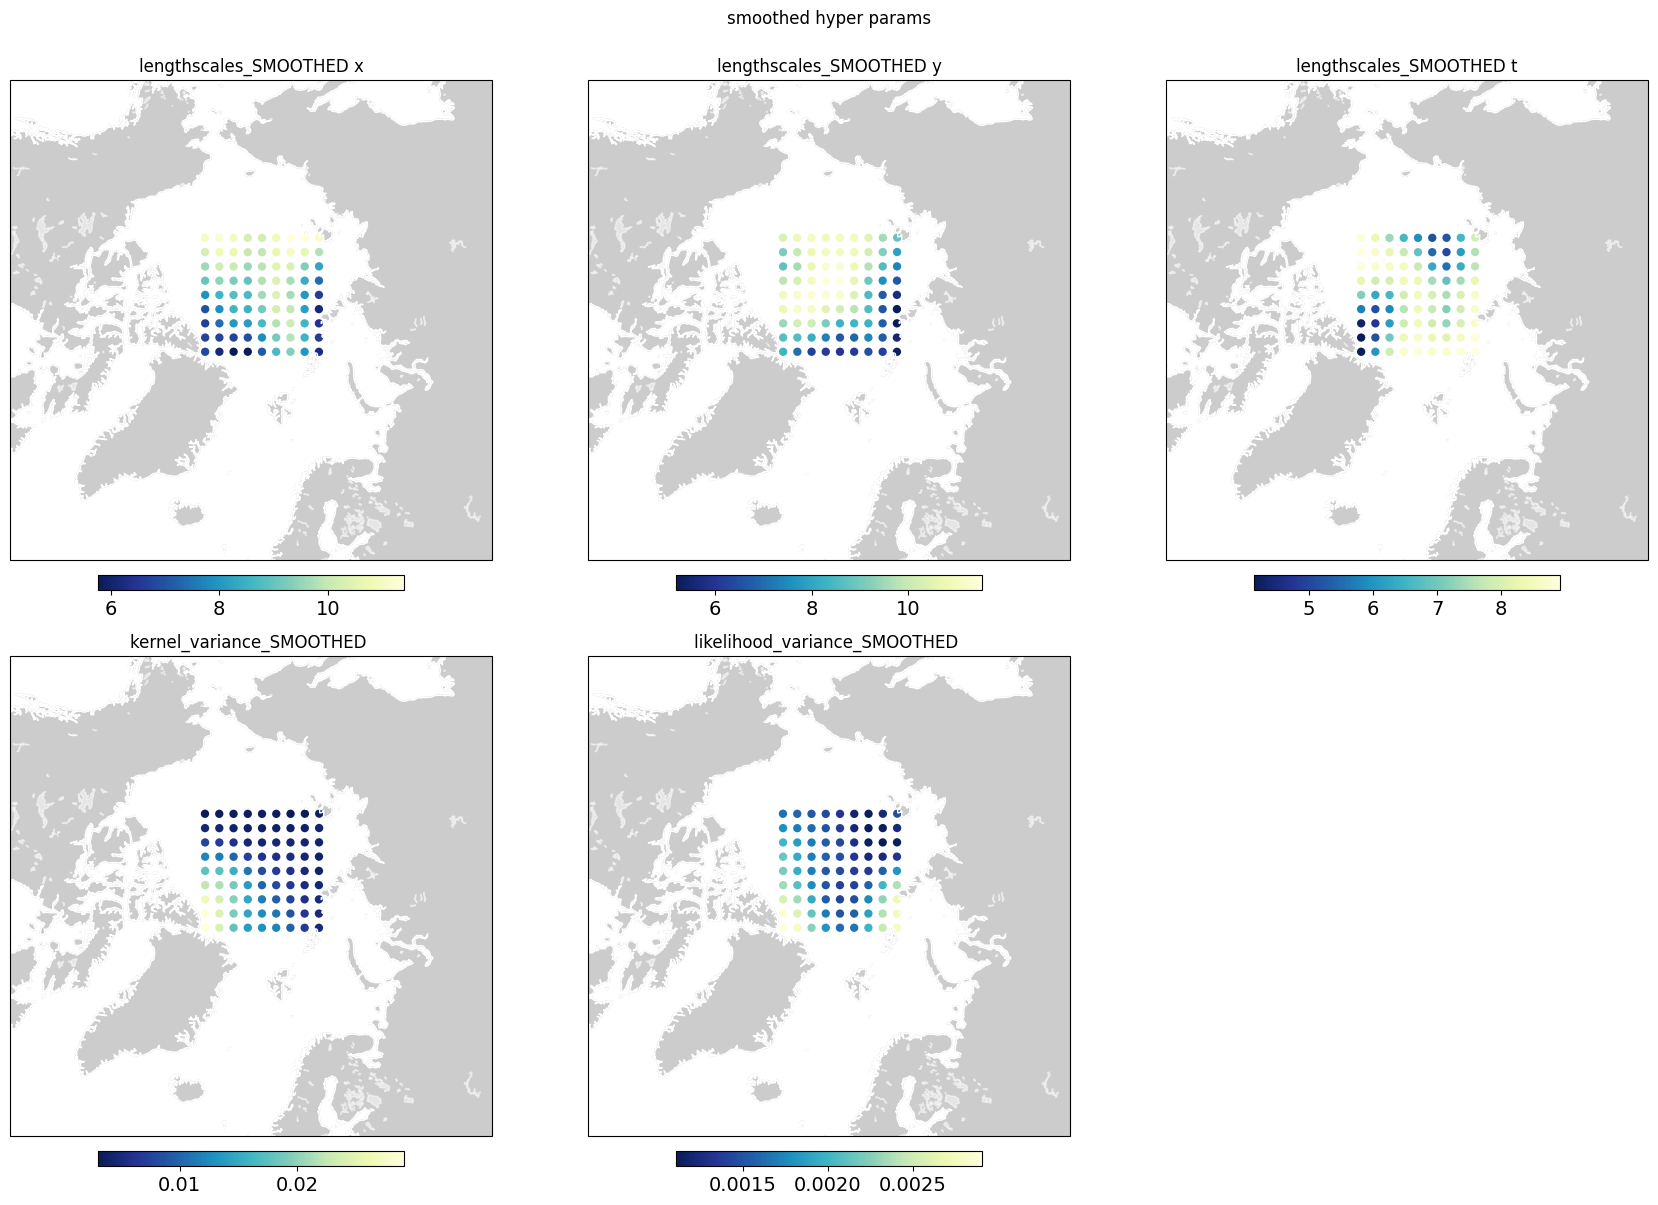

In [20]:

plot_template = {
    "plot_type": "heatmap",
    "x_col": "x",
    "y_col": "y",
    # use a northern hemisphere projection, centered at (lat,lon) = (90,0)
    "subplot_kwargs": {"projection": "north"},
    "lat_0": 90,
    "lon_0": 0,
    # any additional arguments for plot_hist
    "plot_kwargs": {
        "scatter": True,
    },
    # lat/lon_col needed if scatter = True
    # TODO: remove the need for this
    "lat_col": "lat",
    "lon_col": "lon",
}

fig = plot_hyper_parameters(dfs,
                            coords_col=oi_config[0]['data']['coords_col'], # ['x', 'y', 't']
                            row_select=None,
                            table_names=["lengthscales", "kernel_variance", "likelihood_variance"],
                            table_suffix=smooth_config["table_suffix"],
                            plot_template=plot_template,
                            plots_per_row=3,
                            suptitle="smoothed hyper params",
                            qvmin=0.01,
                            qvmax=0.99)

plt.tight_layout()
plt.show()


# plot the (weighted) predictions


'data_select': 0.002 seconds
'load': 0.004 seconds
'plot_pcolormesh': 0.069 seconds


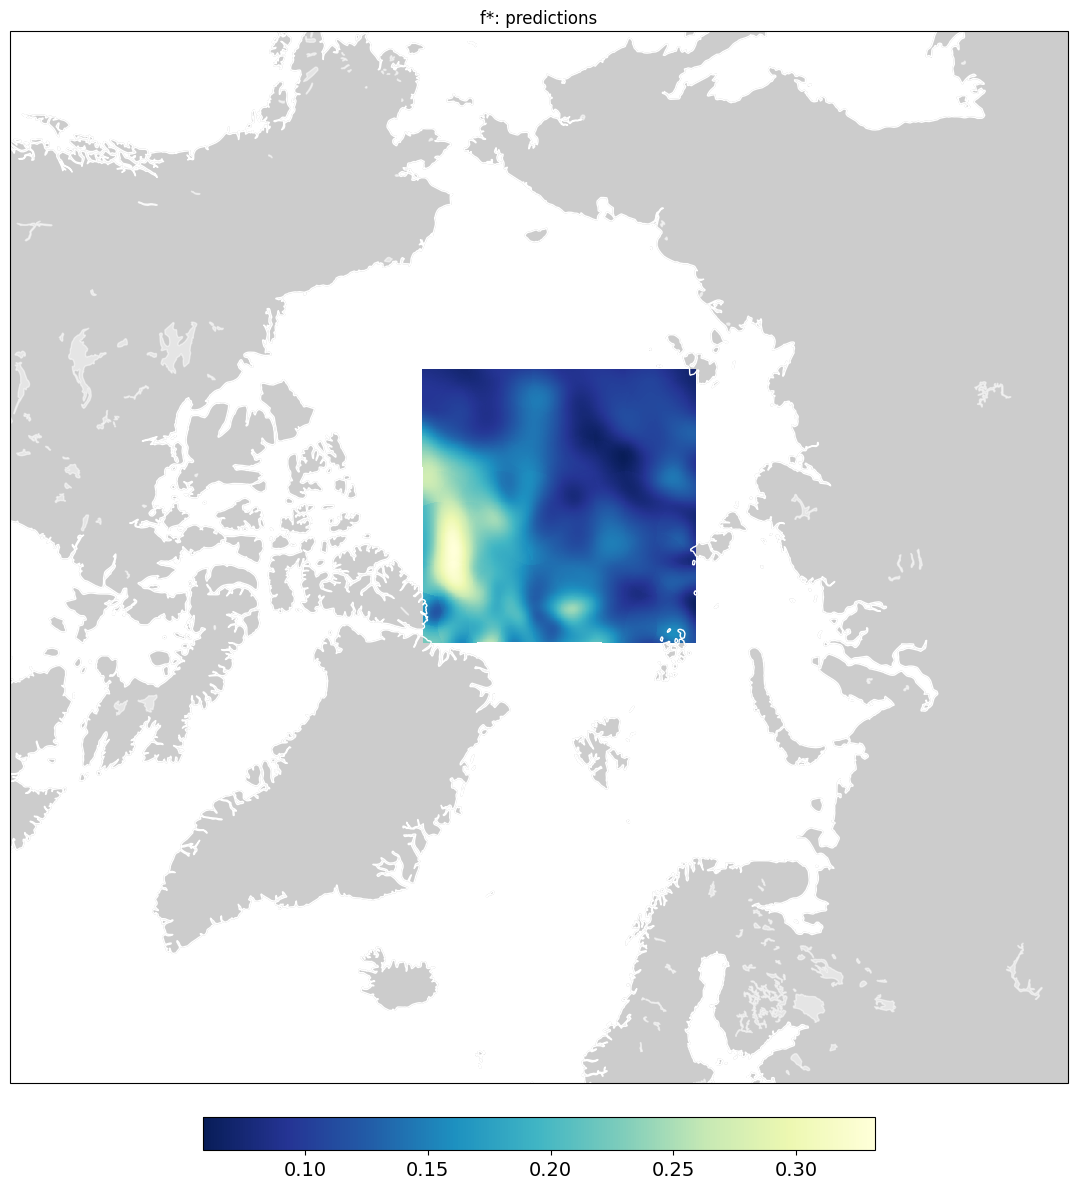

In [21]:
# plt_data = dfs["preds"]
plt_data = dfs["preds" + smooth_config['table_suffix']]

# multiple local experts may make predictions at the same prediction location (pred_loc).
# - for each prediction at a given location, take we weighted combination
# - weights being a function of the distance to each local expert that made a prediction at a given location.
weighted_values_kwargs = {
        "ref_col": ["pred_loc_x", "pred_loc_y", "pred_loc_t"],
        "dist_to_col": ["x", "y", "t"],
        "val_cols": ["f*", "f*_var"],
        "weight_function": "gaussian",
        "lengthscale": 200_000
    }
plt_data = get_weighted_values(df=plt_data, **weighted_values_kwargs)

# add convert x,y to lon,lat
plt_data['lon'], plt_data['lat'] = EASE2toWGS84_New(plt_data['pred_loc_x'], plt_data['pred_loc_y'])


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection('north'))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  scatter=False,
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig,
                                  plot_kwargs={"title": "f*: predictions"},
                                  vmin=vmin,
                                  vmax=vmax)
plt.tight_layout()
plt.show()





